In [6]:
from sklearn.naive_bayes import MultinomialNB
from audioop import cross
from contextlib import redirect_stdout
from sklearn.model_selection import StratifiedKFold
from mealpy.swarm_based import AO, HGS, SSA, MRFO, HHO
from matplotlib import pyplot
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std

DEFAULT_PARAMS = [0.0001, 0.1, 1e-3]

# ling_spam_RSCV_clf = get_best('RSCV', X_ling_spam, y_ling_spam)
# print(ling_spam_RSCV_clf)
# # print(accuracy_score(ling_spam_RSCV_clf, X_spam_assasin, y_spam_assasin, cv=10))

# print(
#     f'Train cross-val accuracy ling_spam_RSCV {mean(cross_val_score(ling_spam_RSCV, X_spam_assasin, y_spam_assasin, cv=10))}')
#     clf = Pipeline([
#         ('tfidf_vectorizer', TfidfVectorizer(
#             stop_words=stopwords.words('english'))),
#         ('clf', SGDClassifier(random_state=0, alpha=alpha, epsilon=epsilon, tol=tol, n_jobs=-1))])

#     accuracy = cross_val_score(clf, X, y, cv=10)

#     clf.fit(X, y)
#     y_score = clf.decision_function(X2)
#     y_pred = clf.predict(X2)

#     print('Params', alpha, epsilon, tol)
#     print(f'Alg: {alg}')
#     print(f'Train Accuracy mean: {mean(accuracy)}')
#     print(f'Accuracy: {accuracy_score(y2, y_pred)}')
#     print(f'Confusion matrix {confusion_matrix(y2, y_pred)}')
#     print(f'ROC: {roc_auc_score(y2, y_pred)}')
#     print()

# a, e, t = get_best("SSA", X_ling_spam, y_ling_spam)
# # print(a, e, t)
# # 0.09670399032960833 607.4605402791983 504.9091755488982
# clf = Pipeline([
#     ('tfidf_vectorizer', TfidfVectorizer(
#         stop_words=stopwords.words('english'))),
#     # ('clf', SGDClassifier(random_state=0, n_jobs=-1, alpha=0.0967, epsilon=607, tol=505))])
#     # ('clf', SGDClassifier(random_state=0, n_jobs=-1))])
#     ('clf', SGDClassifier(random_state=0, n_jobs=-1, alpha=a, epsilon=e, tol=t))])

# clf.fit(X_ling_spam, y_ling_spam)

# y_pred = clf.predict(X_ling_spam)
# # y_score = clf.decision_function(y_ling_spam)

# # print('LS ROC: ', roc_auc_score(y_ling_spam, y_score))
# print('LS ACC: ', accuracy_score(y_ling_spam, y_pred))

# y_pred = clf.predict(X_enron)
# # y_score = clf.decision_function(X_enron)

# # print('EN ROC: ', roc_auc_score(y_enron, y_score))
# print('EN ACC: ', accuracy_score(y_enron, y_pred))

# y_pred = clf.predict(X_spam_assasin)
# # y_score = clf.decision_function(y_spam_assasin)

# # print('SA ROC: ', roc_auc_score(y_spam_assasin, y_score))
# print('SA ACC: ', accuracy_score(y_spam_assasin, y_pred))

In [33]:
enron = pd.read_csv(f'./input/enron/messages.csv').fillna(' ')
X_enron = np.array(enron['message'])
y_enron = np.array(enron['label'])

ling_spam = pd.read_csv(f'./input/ling_spam/messages.csv').fillna(' ')
X_ling_spam = np.array(ling_spam['message'])
y_ling_spam = np.array(ling_spam['label'])

spam_assasin = pd.read_csv(f'./input/spam_assasin/messages.csv').fillna(' ')
X_spam_assasin = np.array(spam_assasin['message'])
y_spam_assasin = np.array(spam_assasin['label'])

In [30]:
def resolve_dataset(name):
    if (name == 'Enron'):
        return [X_enron.copy(), y_enron.copy()]
    elif (name == 'Ling Spam'):
        return [X_ling_spam.copy(), y_ling_spam.copy()]
    elif (name == 'Spam Assasin'):
        return [X_spam_assasin.copy(), y_spam_assasin.copy()]
    else:
        return


def resolve_alg(alg):
    if alg == 'AO':
        return AO.OriginalAO
    elif alg == 'HGS':
        return HGS.OriginalHGS
    elif alg == 'SSA':
        return SSA.OriginalSSA
    elif alg == 'MRFO':
        return MRFO.BaseMRFO

In [9]:
def get_best(alg, X, y):
    if (alg == 'RSCV'):
        distributions = {
            'clf__epsilon': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'clf__tol': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
        skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        clf = Pipeline([
            ('tfidf_vectorizer', TfidfVectorizer(
                stop_words=stopwords.words('english'))),
            ('clf', SGDClassifier(random_state=0, n_jobs=-1))])

        clf_random = RandomizedSearchCV(
            clf, distributions, scoring='accuracy', cv=skf, random_state=0)
        clf_random.fit(X, y)
        best = clf_random.best_params_

        return [best['clf__alpha'], best['clf__epsilon'], best['clf__tol']]

    alg = resolve_alg(alg)
    cv = TfidfVectorizer(stop_words=stopwords.words('english'))
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

    alpha, epsilon, tol = [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = cv.fit_transform(X_train)
        X_test = cv.transform(X_test)

        def obj_function(solution):
            alpha, epsilon, tol = solution
            clf = SGDClassifier(random_state=0, alpha=alpha,
                                epsilon=epsilon, tol=tol, n_jobs=-1)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            return accuracy_score(y_test, y_pred)

        problem = {
            'fit_func': obj_function,
            'lb': [0.0001, 0.0001, 0.0001],
            'ub': [1000, 1000, 1000],
            'minmax': 'max',
            'verbose': True,
        }

        model = alg(problem, epoch=10, pop_size=40)
        model.solve()
        a, e, t = model.g_best[0]
        alpha.append(a)
        epsilon.append(e)
        tol.append(t)

    return [mean(alpha), mean(epsilon), mean(tol)]

In [10]:
best_ling_spam_RSCV = get_best('RSCV', X_ling_spam, y_ling_spam)

In [13]:
best_ling_spam_MRFO = get_best('MRFO', X_ling_spam, y_ling_spam)

2022/04/04 01:16:18 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:18 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:18 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:18 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:18 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:18 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:18 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:18 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:18 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 01:16:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.57911 seconds
2022/04/04 01:16:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.58796 seconds
2022/04/04 01:16:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.58796 seconds
2022/04/04 01:16:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.58796 seconds
2022/04/04 01:16:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.58796 seconds
2022/04/04 01:16:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.58796 seconds
2022/04/04

2022/04/04 01:16:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.53590 seconds
2022/04/04 01:16:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.53590 seconds
2022/04/04 01:16:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.53590 seconds
2022/04/04 01:16:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.53590 seconds
2022/04/04 01:16:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.53590 seconds
2022/04/04 01:16:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.53590 seconds
2022/04/04

2022/04/04 01:16:27 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.56930 seconds
2022/04/04 01:16:27 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.56930 seconds
2022/04/04 01:16:27 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.56930 seconds
2022/04/04 01:16:27 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.56930 seconds
2022/04/04 01:16:27 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.56930 seconds
2022/04/04 01:16:27 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.56930 seconds
2022/04/04

2022/04/04 01:16:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.49431 seconds
2022/04/04 01:16:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.49431 seconds
2022/04/04 01:16:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.49431 seconds
2022/04/04 01:16:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.49431 seconds
2022/04/04 01:16:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.49431 seconds
2022/04/04 01:16:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.49431 seconds
2022/04/04

2022/04/04 01:16:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.61301 seconds
2022/04/04 01:16:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.61301 seconds


2022/04/04 01:16:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.50278 seconds
2022/04/04 01:16:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.50278 seconds
2022/04/04 01:16:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.50278 seconds
2022/04/04 01:16:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.50278 seconds
2022/04/04 01:16:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.50278 seconds
2022/04/04 01:16:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.50278 second

2022/04/04 01:16:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.50804 seconds
2022/04/04 01:16:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.50804 seconds
2022/04/04 01:16:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.50804 seconds
2022/04/04 01:16:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.50804 seconds
2022/04/04 01:16:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.50804 seconds
2022/04/04 01:16:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.50804 second

2022/04/04 01:16:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.70884 seconds
2022/04/04 01:16:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.70884 seconds
2022/04/04 01:16:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.70884 seconds
2022/04/04 01:16:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.70884 seconds
2022/04/04 01:16:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.70884 seconds
2022/04/04 01:16:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.70884 second

2022/04/04 01:16:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55651 seconds
2022/04/04 01:16:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55651 seconds
2022/04/04 01:16:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55651 seconds
2022/04/04 01:16:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55651 seconds
2022/04/04 01:16:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55651 seconds
2022/04/04 01:16:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55651 second

2022/04/04 01:16:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62847 seconds
2022/04/04 01:16:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62847 seconds
2022/04/04 01:16:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62847 seconds
2022/04/04 01:16:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62847 seconds
2022/04/04 01:16:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62847 seconds
2022/04/04 01:16:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62847 second

2022/04/04 01:16:48 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.64732 seconds
2022/04/04 01:16:48 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.64732 seconds
2022/04/04 01:16:48 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.64732 seconds
2022/04/04 01:16:48 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.64732 seconds
2022/04/04 01:16:48 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.64732 seconds
2022/04/04 01:16:48 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.64732 second

2022/04/04 01:16:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.02437 seconds
2022/04/04 01:16:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.02437 seconds
2022/04/04 01:16:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.02437 seconds
2022/04/04 01:16:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.02437 seconds
2022/04/04 01:16:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.20931 seconds
2022/04/04 01:16:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.20931 second

2022/04/04 01:16:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.08945 seconds
2022/04/04 01:16:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.08945 seconds
2022/04/04 01:16:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.08945 seconds
2022/04/04 01:16:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.08945 seconds
2022/04/04 01:16:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.08945 seconds
2022/04/04 01:16:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.08945 second

2022/04/04 01:16:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:16:59 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:17:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, 

2022/04/04 01:17:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.53107 seconds
2022/04/04 01:17:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.53107 seconds
2022/04/04 01:17:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.53107 seconds
2022/04/04 01:17:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.53107 seconds
2022/04/04 01:17:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.53107 seconds
2022/04/04 01:17:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.53107 seconds
2022/04/04 01:17:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.53107 seconds
2022/04/04 01:17:01 AM, INFO, mealpy.swar

2022/04/04 01:17:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.58242 seconds
2022/04/04 01:17:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.58242 seconds
2022/04/04 01:17:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.58242 seconds
2022/04/04 01:17:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.58242 seconds
2022/04/04 01:17:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.58242 seconds
2022/04/04 01:17:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.58242 seconds
2022/04/04 01:17:04 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.58242 seconds
2022/04/04 01:17:04 AM, INFO, mealpy.swar

2022/04/04 01:17:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.69941 seconds
2022/04/04 01:17:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.69941 seconds
2022/04/04 01:17:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.69941 seconds
2022/04/04 01:17:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.69941 seconds
2022/04/04 01:17:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.69941 seconds
2022/04/04 01:17:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.69941 second

2022/04/04 01:17:08 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56393 seconds
2022/04/04 01:17:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.71335 seconds
2022/04/04 01:17:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.71335 seconds
2022/04/04 01:17:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.71335 seconds
2022/04/04 01:17:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.71335 seconds
2022/04/04 01:17:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.71335 second

2022/04/04 01:17:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55487 seconds
2022/04/04 01:17:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55487 seconds
2022/04/04 01:17:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.73965 seconds
2022/04/04 01:17:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.73965 seconds
2022/04/04 01:17:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.73965 seconds
2022/04/04 01:17:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.73965 second

2022/04/04 01:17:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56895 seconds
2022/04/04 01:17:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56895 seconds
2022/04/04 01:17:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56895 seconds
2022/04/04 01:17:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61768 seconds
2022/04/04 01:17:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61768 seconds
2022/04/04 01:17:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61768 sec

2022/04/04 01:17:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.61708 seconds
2022/04/04 01:17:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.61708 seconds
2022/04/04 01:17:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.61708 seconds
2022/04/04 01:17:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.61708 seconds
2022/04/04 01:17:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.61708 seconds
2022/04/04 01:17:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.61708 seconds
2022/04/04

2022/04/04 01:17:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60358 seconds
2022/04/04 01:17:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60358 seconds
2022/04/04 01:17:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60358 seconds
2022/04/04 01:17:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60358 seconds
2022/04/04 01:17:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.83909 seconds
2022/04/04 01:17:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.83909 second

2022/04/04 01:17:19 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60876 seconds
2022/04/04 01:17:19 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60876 seconds
2022/04/04 01:17:19 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60876 seconds
2022/04/04 01:17:19 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60876 seconds
2022/04/04 01:17:19 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60876 seconds
2022/04/04 01:17:19 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.60876 second

2022/04/04 01:17:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.55331 seconds
2022/04/04 01:17:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.55331 seconds
2022/04/04 01:17:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.55331 seconds
2022/04/04 01:17:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.55331 seconds
2022/04/04 01:17:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.55331 seconds
2022/04/04 01:17:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.55331 

2022/04/04 01:17:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.99342 seconds
2022/04/04 01:17:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.99342 seconds
2022/04/04 01:17:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.99342 seconds
2022/04/04 01:17:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.99342 seconds
2022/04/04 01:17:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.99342 seconds
2022/04/04 01:17:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.99342 second

2022/04/04 01:17:27 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.39268 seconds
2022/04/04 01:17:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.40744 seconds
2022/04/04 01:17:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.40744 seconds
2022/04/04 01:17:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.40744 seconds
2022/04/04 01:17:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.40744 seconds
2022/04/04 01:17:29 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.40744 second

2022/04/04 01:17:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.27135 seconds
2022/04/04 01:17:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.27135 seconds
2022/04/04 01:17:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.27135 seconds
2022/04/04 01:17:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.27135 seconds
2022/04/04 01:17:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.27135 seconds
2022/04/04 01:17:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.27135 second

2022/04/04 01:17:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.06151 seconds
2022/04/04 01:17:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.06151 seconds
2022/04/04 01:17:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.06151 seconds
2022/04/04 01:17:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.06151 seconds
2022/04/04 01:17:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.06151 seconds
2022/04/04 01:17:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.06151 

2022/04/04 01:17:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.87332 seconds
2022/04/04 01:17:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.87332 seconds
2022/04/04 01:17:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.87332 seconds
2022/04/04 01:17:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.87332 seconds
2022/04/04 01:17:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.87332 seconds
2022/04/04 01:17:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.87332 second

2022/04/04 01:17:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.68969 seconds
2022/04/04 01:17:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.68969 seconds
2022/04/04 01:17:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.68969 seconds
2022/04/04 01:17:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.68969 seconds
2022/04/04 01:17:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.68969 seconds
2022/04/04 01:17:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.68969 second

2022/04/04 01:17:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.64786 seconds
2022/04/04 01:17:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.64786 seconds
2022/04/04 01:17:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.64786 seconds
2022/04/04 01:17:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.64786 seconds
2022/04/04 01:17:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.64786 seconds
2022/04/04 01:17:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.64786 second

2022/04/04 01:17:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.68768 seconds
2022/04/04 01:17:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.68768 seconds
2022/04/04 01:17:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.68768 seconds
2022/04/04 01:17:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.68768 seconds
2022/04/04 01:17:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.68768 seconds
2022/04/04 01:17:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.68768 second

In [14]:
best_ling_spam_HGS = get_best('HGS', X_ling_spam, y_ling_spam)

2022/04/04 01:20:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 01:20:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.62178 seconds
2022/04/04 01:20:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.62178 seconds
2022/04/04 01:20:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.60626 seconds
2022/04/04 01:20:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.60626 seconds
2022/04/04 01:20:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.60626 seconds
2022/04/04 01:20:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.60626 second

2022/04/04 01:20:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.75698 seconds
2022/04/04 01:20:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.75698 seconds
2022/04/04 01:20:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.75698 seconds
2022/04/04 01:20:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.75698 seconds
2022/04/04 01:20:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.75698 seconds
2022/04/04 01:20:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.75698 second

2022/04/04 01:20:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.47403 seconds
2022/04/04 01:20:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.52183 seconds
2022/04/04 01:20:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.52183 seconds
2022/04/04 01:20:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.52183 seconds
2022/04/04 01:20:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.52183 seconds
2022/04/04 01:20:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.52183 second

2022/04/04 01:20:35 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.80592 seconds
2022/04/04 01:20:35 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.80592 seconds
2022/04/04 01:20:35 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.80592 seconds
2022/04/04 01:20:35 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.80592 seconds
2022/04/04 01:20:35 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.80592 seconds
2022/04/04 01:20:35 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.80592 second

2022/04/04 01:20:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 01:20:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.48779 seconds
2022/04/04 01:20:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.48779 seconds
2022/04/04 01:20:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.48779 seconds
2022/04/04 01:20:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.48779 seconds
2022/04/04 01:20:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.48779 seconds
2022/04/04 01:20:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.

2022/04/04 01:20:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.57212 seconds
2022/04/04 01:20:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.57212 seconds
2022/04/04 01:20:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.57212 seconds
2022/04/04 01:20:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.57212 seconds
2022/04/04 01:20:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.57212 seconds
2022/04/04 01:20:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.

2022/04/04 01:20:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42518 seconds
2022/04/04 01:20:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42518 seconds
2022/04/04 01:20:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42518 seconds
2022/04/04 01:20:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42518 seconds
2022/04/04 01:20:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42518 seconds
2022/04/04 01:20:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 01:20:47 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.64893 seconds
2022/04/04 01:20:47 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.64893 seconds
2022/04/04 01:20:47 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.64893 seconds
2022/04/04 01:20:47 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.64893 seconds
2022/04/04 01:20:47 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.64893 seconds
2022/04/04 01:20:47 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 01:20:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.82456 seconds
2022/04/04 01:20:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.82456 seconds
2022/04/04 01:20:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.82456 seconds
2022/04/04 01:20:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.82456 seconds
2022/04/04 01:20:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.82456 seconds
2022/04/04 01:20:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 01:20:52 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:52 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:52 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:20:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.41939 seconds
2022/04/04 01:20:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.41939 seconds
2022/04/04 01:20:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.41939 seconds
2022/04/04 01:20:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0

2022/04/04 01:20:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65220 seconds
2022/04/04 01:20:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65220 seconds
2022/04/04 01:20:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65220 seconds
2022/04/04 01:20:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65220 seconds
2022/04/04 01:20:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65220 seconds
2022/04/04 01:20:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 01:20:57 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61304 seconds
2022/04/04 01:20:57 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61304 seconds
2022/04/04 01:20:57 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61304 seconds
2022/04/04 01:20:57 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61304 seconds
2022/04/04 01:20:57 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61304 seconds
2022/04/04 01:20:57 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 01:20:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67422 seconds
2022/04/04 01:20:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67422 seconds
2022/04/04 01:20:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67422 seconds
2022/04/04 01:20:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67422 seconds
2022/04/04 01:20:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67422 seconds
2022/04/04 01:21:00 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:00 AM, INFO, mealpy.

2022/04/04 01:21:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.48092 seconds
2022/04/04 01:21:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.48092 seconds
2022/04/04 01:21:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.48092 seconds
2022/04/04 01:21:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.48092 seconds
2022/04/04 01:21:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.48092 seconds
2022/04/04 01:21:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 01:21:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.57515 seconds
2022/04/04 01:21:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.57515 seconds
2022/04/04 01:21:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.57515 seconds
2022/04/04 01:21:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.57515 seconds
2022/04/04 01:21:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.57515 seconds
2022/04/04 01:21:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.57515 seconds
2022/04/04 01:21:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.57515 seconds
2022/04/04 01:21:04 AM, INF

2022/04/04 01:21:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46591 seconds
2022/04/04 01:21:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46591 seconds
2022/04/04 01:21:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46591 seconds
2022/04/04 01:21:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46591 seconds
2022/04/04 01:21:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46591 seconds
2022/04/04 01:21:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46591 seconds
2022/04/04 01:21:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.46591 seconds
2022/04/04 01:21:06 

2022/04/04 01:21:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45527 seconds
2022/04/04 01:21:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45527 seconds
2022/04/04 01:21:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45527 seconds
2022/04/04 01:21:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45527 seconds
2022/04/04 01:21:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45527 seconds
2022/04/04 01:21:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 01:21:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53342 seconds
2022/04/04 01:21:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53342 seconds
2022/04/04 01:21:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53342 seconds
2022/04/04 01:21:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53342 seconds
2022/04/04 01:21:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53342 seconds
2022/04/04 01:21:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 01:21:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56004 seconds
2022/04/04 01:21:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56004 seconds
2022/04/04 01:21:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56004 seconds
2022/04/04 01:21:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56004 seconds
2022/04/04 01:21:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56004 seconds
2022/04/04 01:21:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 01:21:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 01:21:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.55909 seconds
2022/04/04 01:21:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.55909 seconds
2022/04/04 01:21:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.55909 seconds
2022/04/04 01:21:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.55909 seconds
2022/04/04 01:21:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.55909 seconds
2022/04/04 01:21:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.

2022/04/04 01:21:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.69271 seconds
2022/04/04 01:21:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.69271 seconds
2022/04/04 01:21:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.69271 seconds
2022/04/04 01:21:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.69271 seconds
2022/04/04 01:21:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.69271 seconds
2022/04/04 01:21:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.

2022/04/04 01:21:18 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.73158 seconds
2022/04/04 01:21:18 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.73158 seconds
2022/04/04 01:21:18 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.73158 seconds
2022/04/04 01:21:18 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.73158 seconds
2022/04/04 01:21:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.74741 seconds
2022/04/04 01:21:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9826989619377162, Global best: 0.9826989619377162, Runtime: 0.

2022/04/04 01:21:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.37260 seconds
2022/04/04 01:21:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 

2022/04/04 01:21:22 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.45848 seconds
2022/04/04 01:21:22 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.45848 seconds
2022/04/04 01:21:22 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.45848 seconds
2022/04/04 01:21:22 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.45848 seconds
2022/04/04 01:21:22 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.45848 seconds
2022/04/04 01:21:22 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 01:21:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51392 seconds
2022/04/04 01:21:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51175 seconds
2022/04/04 01:21:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51175 seconds
2022/04/04 01:21:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51175 seconds
2022/04/04 01:21:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.51175 seconds
2022/04/04 01:21:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 01:21:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.52861 seconds
2022/04/04 01:21:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.52861 seconds
2022/04/04 01:21:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.52861 seconds
2022/04/04 01:21:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.52861 seconds
2022/04/04 01:21:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.52861 seconds
2022/04/04 01:21:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 01:21:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 01:21:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 01:21:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.54012 seconds
2022/04/04 01:21:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.54012 seconds
2022/04/04 01:21:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.55669 seconds
2022/04/04 01:21:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.55669 seconds
2022/04/04 01:21:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.55669 seconds
2022/04/04 01:21:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.

2022/04/04 01:21:30 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.59476 seconds
2022/04/04 01:21:30 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.59476 seconds
2022/04/04 01:21:30 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.59476 seconds
2022/04/04 01:21:30 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.59476 seconds
2022/04/04 01:21:30 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.59476 seconds
2022/04/04 01:21:30 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.

2022/04/04 01:21:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.91477 seconds
2022/04/04 01:21:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.91477 seconds
2022/04/04 01:21:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.91477 seconds
2022/04/04 01:21:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.91477 seconds
2022/04/04 01:21:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.71768 seconds
2022/04/04 01:21:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.

2022/04/04 01:21:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.63962 seconds
2022/04/04 01:21:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.63962 seconds
2022/04/04 01:21:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.63962 seconds
2022/04/04 01:21:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.63962 seconds
2022/04/04 01:21:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.63962 seconds
2022/04/04 01:21:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runti

In [18]:
best_ling_spam_AO = get_best('AO', X_ling_spam, y_ling_spam)

2022/04/04 01:25:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 01:25:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 01:25:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 01:25:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 01:25:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 01:25:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 01:25:04 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.8344827586206897, Global best: 0.8344827586206897, Runtime: 0.40619 seconds
2022/04/04 01:25:04 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.8344827586206897, Global best: 0.8344827586206897, Runtime: 0.40619 seconds


2022/04/04 01:25:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.68952 seconds
2022/04/04 01:25:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.68952 seconds
2022/04/04 01:25:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.85700 seconds
2022/04/04 01:25:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.85700 seconds
2022/04/04 01:25:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.85700 seconds
2022/04/04 01:25:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.85700 seconds
2022/04/04

2022/04/04 01:25:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45572 seconds
2022/04/04 01:25:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45572 seconds
2022/04/04 01:25:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45572 seconds
2022/04/04 01:25:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.45572 seconds
2022/04/04 01:25:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.33933 seconds
2022/04/04 01:25:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.33933 seconds
2022/04/04

2022/04/04 01:25:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.43861 seconds
2022/04/04 01:25:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.43861 seconds
2022/04/04 01:25:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.40598 seconds
2022/04/04 01:25:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.40598 seconds
2022/04/04 01:25:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.40598 seconds
2022/04/04 01:25:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.40598 second

2022/04/04 01:25:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 1.26675 seconds
2022/04/04 01:25:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 1.26675 seconds
2022/04/04 01:25:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 1.26675 seconds
2022/04/04 01:25:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 1.26675 seconds
2022/04/04 01:25:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 1.26675 seconds
2022/04/04 01:25:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 1.26675 second

2022/04/04 01:25:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.33587 seconds
2022/04/04 01:25:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.33587 seconds
2022/04/04 01:25:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.33587 seconds
2022/04/04 01:25:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.33587 seconds
2022/04/04 01:25:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.33587 seconds
2022/04/04 01:25:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.33587 second

2022/04/04 01:25:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.78899 seconds
2022/04/04 01:25:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.78899 seconds
2022/04/04 01:25:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.60134 seconds
2022/04/04 01:25:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.60134 seconds
2022/04/04 01:25:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.60134 seconds
2022/04/04 01:25:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.60134 second

2022/04/04 01:25:32 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40000 seconds
2022/04/04 01:25:32 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40000 seconds
2022/04/04 01:25:32 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40000 seconds
2022/04/04 01:25:32 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40000 seconds
2022/04/04 01:25:32 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40000 seconds
2022/04/04 01:25:32 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40000 second

2022/04/04 01:25:35 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27340 seconds
2022/04/04 01:25:35 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27340 seconds
2022/04/04 01:25:35 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27340 seconds
2022/04/04 01:25:35 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27340 seconds
2022/04/04 01:25:35 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27340 seconds
2022/04/04 01:25:35 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.27340 second

2022/04/04 01:25:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.66562 seconds
2022/04/04 01:25:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.66562 seconds
2022/04/04 01:25:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.66562 seconds
2022/04/04 01:25:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.66562 seconds
2022/04/04 01:25:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.66562 seconds
2022/04/04 01:25:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.66562 second

2022/04/04 01:25:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 2.65815 seconds
2022/04/04 01:25:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.39612 seconds
2022/04/04 01:25:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.39612 seconds
2022/04/04 01:25:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.39612 seconds
2022/04/04 01:25:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.39612 seconds
2022/04/04 01:25:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.39612 second

2022/04/04 01:25:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 01:25:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 01:25:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 01:25:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 01:25:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 01:25:48 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.36684 seconds
2022/04/04 01:25:48 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.36684 seconds
2022/04/04 01:25:48 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9965397923875432, Gl

2022/04/04 01:25:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.63316 seconds
2022/04/04 01:25:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.63316 seconds
2022/04/04 01:25:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.07571 seconds
2022/04/04 01:25:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.07571 seconds
2022/04/04 01:25:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.07571 seconds
2022/04/04 01:25:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.07571 second

2022/04/04 01:25:56 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.75113 seconds
2022/04/04 01:25:56 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.75113 seconds
2022/04/04 01:25:56 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.75113 seconds
2022/04/04 01:25:56 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.75113 seconds
2022/04/04 01:25:56 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.75113 seconds
2022/04/04 01:25:56 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.75113 second

2022/04/04 01:25:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.73361 seconds
2022/04/04 01:25:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.73361 seconds
2022/04/04 01:25:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.73361 seconds
2022/04/04 01:25:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.73361 seconds
2022/04/04 01:25:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.73361 seconds
2022/04/04 01:25:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.73361 seconds
2022/04/04

2022/04/04 01:26:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 1.35956 seconds
2022/04/04 01:26:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 1.35956 seconds
2022/04/04 01:26:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 1.35956 seconds
2022/04/04 01:26:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 1.35956 seconds
2022/04/04 01:26:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 1.35956 seconds
2022/04/04 01:26:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 1.35956 seconds
2022/04/04

2022/04/04 01:26:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.85226 seconds
2022/04/04 01:26:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.85226 seconds
2022/04/04 01:26:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.85226 seconds
2022/04/04 01:26:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.85226 seconds
2022/04/04 01:26:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.85226 seconds
2022/04/04 01:26:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.85226 seconds
2022

2022/04/04 01:26:10 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40527 seconds
2022/04/04 01:26:10 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.42536 seconds
2022/04/04 01:26:10 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.42536 seconds
2022/04/04 01:26:10 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.42536 seconds
2022/04/04 01:26:10 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.42536 seconds
2022/04/04 01:26:10 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.42536 second

2022/04/04 01:26:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.35258 seconds
2022/04/04 01:26:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.35258 seconds
2022/04/04 01:26:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.35258 seconds
2022/04/04 01:26:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.35258 seconds
2022/04/04 01:26:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.35258 seconds
2022/04/04 01:26:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.35258 second

2022/04/04 01:26:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.61560 seconds
2022/04/04 01:26:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.61560 seconds
2022/04/04 01:26:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.61560 seconds
2022/04/04 01:26:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.61560 seconds
2022/04/04 01:26:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.61560 seconds
2022/04/04 01:26:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.61560 

2022/04/04 01:26:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.72801 seconds
2022/04/04 01:26:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.72801 seconds
2022/04/04 01:26:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.72801 seconds
2022/04/04 01:26:19 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.00558 seconds
2022/04/04 01:26:19 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.00558 seconds
2022/04/04 01:26:19 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.00558 second

2022/04/04 01:26:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 2.25919 seconds
2022/04/04 01:26:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 2.25919 seconds
2022/04/04 01:26:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 2.25919 seconds
2022/04/04 01:26:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 2.25919 seconds
2022/04/04 01:26:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 2.25919 seconds
2022/04/04 01:26:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 2.25919 second

2022/04/04 01:26:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.92231 seconds
2022/04/04 01:26:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.92231 seconds
2022/04/04 01:26:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.92231 seconds
2022/04/04 01:26:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.92231 seconds
2022/04/04 01:26:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.92231 seconds
2022/04/04 01:26:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.92231 second

In [19]:
best_ling_spam_SSA = get_best('SSA', X_ling_spam, y_ling_spam)

2022/04/04 01:26:26 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 01:26:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.89696 seconds
2022/04/04 01:26:29 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.01356 seconds
2022/04/04 01:26:30 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.00300 seconds
2022/04/04 01:26:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.15696 seconds
2022/04/04 01:26:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 1.15746 seconds
2022/04/04 01:26:33 AM, INFO, mealpy.swarm_based.SSA

2022/04/04 01:26:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.88799 seconds
2022/04/04 01:26:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.88799 seconds
2022/04/04 01:26:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.88799 seconds
2022/04/04 01:26:58 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.93374 seconds
2022/04/04 01:26:58 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.93374 seconds
2022/04/04 01:26:58 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.

2022/04/04 01:27:12 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.44912 seconds
2022/04/04 01:27:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16141 seconds
2022/04/04 01:27:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16141 seconds
2022/04/04 01:27:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16141 seconds
2022/04/04 01:27:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16141 seconds
2022/04/04 01:27:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1

2022/04/04 01:27:25 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.37332 seconds
2022/04/04 01:27:25 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.37332 seconds
2022/04/04 01:27:25 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.37332 seconds
2022/04/04 01:27:27 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.46425 seconds
2022/04/04 01:27:27 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.46425 seconds
2022/04/04 01:27:27 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 01:27:36 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.96525 seconds
2022/04/04 01:27:36 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.96525 seconds
2022/04/04 01:27:36 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.96525 seconds
2022/04/04 01:27:36 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.96525 seconds
2022/04/04 01:27:36 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.96525 seconds
2022/04/04 01:27:37 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.94565 seconds
2022/04/04 01:27:37 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.94565 seconds
2022/04/04 01:27:37 AM, INF

2022/04/04 01:27:44 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.99821 seconds
2022/04/04 01:27:44 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.99821 seconds
2022/04/04 01:27:44 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.99821 seconds
2022/04/04 01:27:44 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.97525 seconds
2022/04/04 01:27:44 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.97525 seconds
2022/04/04 01:27:44 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 01:27:50 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 01:27:50 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 01:27:51 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.71736 seconds
2022/04/04 01:27:51 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.71736 seconds
2022/04/04 01:27:51 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.71736 seconds
2022/04/04 01:27:51 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.71736 seconds
2022/04/04 01:27:51 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9861591695501

2022/04/04 01:27:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.81693 seconds
2022/04/04 01:27:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.81693 seconds
2022/04/04 01:27:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.81693 seconds
2022/04/04 01:27:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.81693 seconds
2022/04/04 01:27:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.81693 seconds
2022/04/04 01:27:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.986159169550173, Global best: 0.986159169550173, Runtime: 0.81693 second

2022/04/04 01:28:01 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.77045 seconds
2022/04/04 01:28:01 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.77045 seconds
2022/04/04 01:28:01 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.77045 seconds
2022/04/04 01:28:01 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.77045 seconds
2022/04/04 01:28:01 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.77045 seconds
2022/04/04 01:28:01 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 01:28:06 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.86767 seconds
2022/04/04 01:28:06 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.86767 seconds
2022/04/04 01:28:06 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.86767 seconds
2022/04/04 01:28:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.88958 seconds
2022/04/04 01:28:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.88958 seconds
2022/04/04 01:28:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 01:28:12 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.31948 seconds
2022/04/04 01:28:12 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.31948 seconds
2022/04/04 01:28:12 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.31948 seconds
2022/04/04 01:28:12 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.31948 seconds
2022/04/04 01:28:12 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.31948 seconds
2022/04/04 01:28:12 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.

2022/04/04 01:28:17 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.28023 seconds
2022/04/04 01:28:17 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.28023 seconds
2022/04/04 01:28:17 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.28023 seconds
2022/04/04 01:28:17 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.28023 seconds
2022/04/04 01:28:17 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.28023 seconds
2022/04/04 01:28:17 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.

In [36]:
best_spam_assasin_RSCV = get_best('RSCV', X_spam_assasin, y_spam_assasin)

In [37]:
best_spam_assasin_MRFO = get_best('MRFO', X_spam_assasin, y_spam_assasin)

2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:51:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 01:51:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.75589 seconds
2022/04/04 01:51:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.75589 seconds
2022/04/04 01:51:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.75589 seconds
2022/04/04 01:51:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.75589 seconds
2022/04/04 01:51:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.75589 seconds
2022/04/04 01:51:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.75589 second

2022/04/04 01:51:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.64538 seconds
2022/04/04 01:51:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.64538 seconds
2022/04/04 01:51:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.64538 seconds
2022/04/04 01:51:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.64538 seconds
2022/04/04 01:51:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.64538 seconds
2022/04/04 01:51:25 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.64538 second

2022/04/04 01:51:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01409 seconds
2022/04/04 01:51:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01409 seconds
2022/04/04 01:51:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01409 seconds
2022/04/04 01:51:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01409 seconds
2022/04/04 01:51:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01409 seconds
2022/04/04 01:51:33 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01409 second

2022/04/04 01:51:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.19932 seconds
2022/04/04 01:51:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.19932 seconds
2022/04/04 01:51:42 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.19932 seconds
2022/04/04 01:51:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 4.61691 seconds
2022/04/04 01:51:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 4.61691 seconds
2022/04/04 01:51:47 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 4.61691 sec

2022/04/04 01:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.51693 seconds
2022/04/04 01:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.51693 seconds
2022/04/04 01:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.51693 seconds
2022/04/04 01:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.51693 seconds
2022/04/04 01:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.51693 seconds
2022/04/04 01:51:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.51693 seconds
2022/04/04

2022/04/04 01:51:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.68256 seconds
2022/04/04 01:51:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.68256 seconds
2022/04/04 01:51:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.68256 seconds
2022/04/04 01:51:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.68256 seconds
2022/04/04 01:51:54 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.68256 seconds
2022/04/04 01:51:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.85671 second

2022/04/04 01:51:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.44238 seconds
2022/04/04 01:51:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.44238 seconds
2022/04/04 01:51:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.44238 seconds
2022/04/04 01:51:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.44238 seconds
2022/04/04 01:51:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.44238 seconds
2022/04/04 01:51:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.44238 second

2022/04/04 01:52:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64808 seconds
2022/04/04 01:52:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64808 seconds
2022/04/04 01:52:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64808 seconds
2022/04/04 01:52:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64808 seconds
2022/04/04 01:52:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64808 seconds
2022/04/04 01:52:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64808 second

2022/04/04 01:52:05 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.56256 seconds
2022/04/04 01:52:05 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.56256 seconds
2022/04/04 01:52:05 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.56256 seconds
2022/04/04 01:52:05 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.56256 seconds
2022/04/04 01:52:05 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.56256 seconds
2022/04/04 01:52:05 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.56256 

2022/04/04 01:52:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.74147 seconds
2022/04/04 01:52:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.74147 seconds
2022/04/04 01:52:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.74147 seconds
2022/04/04 01:52:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.74147 seconds
2022/04/04 01:52:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.74147 seconds
2022/04/04 01:52:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.74147 second

2022/04/04 01:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.58001 seconds
2022/04/04 01:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.58001 seconds
2022/04/04 01:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.58001 seconds
2022/04/04 01:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.58001 seconds
2022/04/04 01:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.58001 seconds
2022/04/04 01:52:14 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.58001 second

2022/04/04 01:52:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.95537 seconds
2022/04/04 01:52:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.95537 seconds
2022/04/04 01:52:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.95537 seconds
2022/04/04 01:52:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.95537 seconds
2022/04/04 01:52:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.95537 seconds
2022/04/04 01:52:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.95537 second

2022/04/04 01:52:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.66410 seconds
2022/04/04 01:52:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.66410 seconds
2022/04/04 01:52:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.66410 seconds
2022/04/04 01:52:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.66410 seconds
2022/04/04 01:52:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.66410 seconds
2022/04/04 01:52:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.66410 second

2022/04/04 01:52:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.39335 seconds
2022/04/04 01:52:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.39335 seconds
2022/04/04 01:52:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.39335 seconds
2022/04/04 01:52:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.39335 seconds
2022/04/04 01:52:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.39335 seconds
2022/04/04 01:52:24 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.39335 

2022/04/04 01:52:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.05332 seconds
2022/04/04 01:52:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.05332 seconds
2022/04/04 01:52:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.05332 seconds
2022/04/04 01:52:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.05332 seconds
2022/04/04 01:52:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.05332 seconds
2022/04/04 01:52:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.05332 second

2022/04/04 01:52:34 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.22024 seconds
2022/04/04 01:52:34 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.22024 seconds
2022/04/04 01:52:34 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.22024 seconds
2022/04/04 01:52:34 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.22024 seconds
2022/04/04 01:52:34 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.22024 seconds
2022/04/04 01:52:34 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.22024 second

2022/04/04 01:52:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.82987 seconds
2022/04/04 01:52:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.82987 seconds
2022/04/04 01:52:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.82987 seconds
2022/04/04 01:52:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.82987 seconds
2022/04/04 01:52:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.82987 seconds
2022/04/04 01:52:38 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.82987 second

2022/04/04 01:52:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.62662 seconds
2022/04/04 01:52:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.62662 seconds
2022/04/04 01:52:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.62662 seconds
2022/04/04 01:52:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.62662 seconds
2022/04/04 01:52:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.62662 seconds
2022/04/04 01:52:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.62662 second

2022/04/04 01:52:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64474 seconds
2022/04/04 01:52:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64474 seconds
2022/04/04 01:52:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64474 seconds
2022/04/04 01:52:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64474 seconds
2022/04/04 01:52:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64474 seconds
2022/04/04 01:52:45 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.64474 

2022/04/04 01:52:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.57261 seconds
2022/04/04 01:52:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.57261 seconds
2022/04/04 01:52:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.57261 seconds
2022/04/04 01:52:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.57261 seconds
2022/04/04 01:52:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.57261 seconds
2022/04/04 01:52:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.57261 second

2022/04/04 01:52:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.49011 seconds
2022/04/04 01:52:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.49011 seconds
2022/04/04 01:52:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.49011 seconds
2022/04/04 01:52:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.49011 seconds
2022/04/04 01:52:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.49011 seconds
2022/04/04 01:52:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.49011 second

2022/04/04 01:52:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52299 seconds
2022/04/04 01:52:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52299 seconds
2022/04/04 01:52:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52299 seconds
2022/04/04 01:52:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52299 seconds
2022/04/04 01:52:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52299 seconds
2022/04/04 01:52:55 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52299 second

2022/04/04 01:52:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.31533 seconds
2022/04/04 01:52:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.31533 seconds
2022/04/04 01:52:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.31533 seconds
2022/04/04 01:52:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.31533 seconds
2022/04/04 01:52:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.31533 seconds
2022/04/04 01:52:57 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.31533 second

2022/04/04 01:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52285 seconds
2022/04/04 01:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52285 seconds
2022/04/04 01:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52285 seconds
2022/04/04 01:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52285 seconds
2022/04/04 01:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52285 seconds
2022/04/04 01:53:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9945828819068255, Global best: 0.9945828819068255, Runtime: 1.52285 second

2022/04/04 01:53:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.11968 seconds
2022/04/04 01:53:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.11968 seconds
2022/04/04 01:53:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.11968 seconds
2022/04/04 01:53:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.11968 seconds
2022/04/04 01:53:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.11968 seconds
2022/04/04 01:53:07 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.11968 second

2022/04/04 01:53:11 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.73575 seconds
2022/04/04 01:53:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.75285 seconds
2022/04/04 01:53:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.75285 seconds
2022/04/04 01:53:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.75285 seconds
2022/04/04 01:53:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.75285 seconds
2022/04/04 01:53:15 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.75285 second

2022/04/04 01:53:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 5.36722 seconds
2022/04/04 01:53:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 5.36722 seconds
2022/04/04 01:53:21 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 5.36722 seconds
2022/04/04 01:53:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.91320 seconds
2022/04/04 01:53:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.91320 seconds
2022/04/04 01:53:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.91320 second

2022/04/04 01:53:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.48571 seconds
2022/04/04 01:53:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.48571 seconds
2022/04/04 01:53:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.48571 seconds
2022/04/04 01:53:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.48571 seconds
2022/04/04 01:53:30 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.48571 seconds
2022/04/04 01:53:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65844 second

2022/04/04 01:53:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65505 seconds
2022/04/04 01:53:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65505 seconds
2022/04/04 01:53:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65505 seconds
2022/04/04 01:53:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65505 seconds
2022/04/04 01:53:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65505 seconds
2022/04/04 01:53:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.65505 second

2022/04/04 01:53:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.89569 seconds
2022/04/04 01:53:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.89569 seconds
2022/04/04 01:53:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.89569 seconds
2022/04/04 01:53:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.89569 seconds
2022/04/04 01:53:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.89569 seconds
2022/04/04 01:53:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.89569 

2022/04/04 01:53:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11873 seconds
2022/04/04 01:53:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11873 seconds
2022/04/04 01:53:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11873 seconds
2022/04/04 01:53:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11873 seconds
2022/04/04 01:53:53 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11873 seconds
2022/04/04 01:53:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.00269 seconds
2022/04/04

2022/04/04 01:54:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.42476 seconds
2022/04/04 01:54:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.42476 seconds
2022/04/04 01:54:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.42476 seconds
2022/04/04 01:54:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.42476 seconds
2022/04/04 01:54:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.42476 seconds
2022/04/04 01:54:01 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.42476 seconds
2022/04/04

2022/04/04 01:54:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.97021 seconds
2022/04/04 01:54:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.97021 seconds
2022/04/04 01:54:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.97021 seconds
2022/04/04 01:54:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.97021 seconds
2022/04/04 01:54:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.97021 seconds
2022/04/04 01:54:09 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.97021 seconds
2022/04/04

2022/04/04 01:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.06752 seconds
2022/04/04 01:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.06752 seconds
2022/04/04 01:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.06752 seconds
2022/04/04 01:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.06752 seconds
2022/04/04 01:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.06752 seconds
2022/04/04 01:54:17 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.06752 seconds
2022/04/04

2022/04/04 01:54:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.28063 seconds
2022/04/04 01:54:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.28063 seconds
2022/04/04 01:54:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.28063 seconds
2022/04/04 01:54:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.28063 seconds
2022/04/04 01:54:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.28063 seconds
2022/04/04 01:54:26 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 4.28063 seconds
2022/04/04

2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:32 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 01:54:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.52589 seconds
2022/04/04 01:54:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.52589 seconds
2022/04/04 01:54:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.52589 seconds
2022/04/04 01:54:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.52589 seconds
2022/04/04 01:54:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.52589 seconds
2022/04/04 01:54:37 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.52589 second

2022/04/04 01:54:39 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.93219 seconds
2022/04/04 01:54:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.84835 seconds
2022/04/04 01:54:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.84835 seconds
2022/04/04 01:54:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.84835 seconds
2022/04/04 01:54:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.84835 seconds
2022/04/04 01:54:41 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.84835 second

2022/04/04 01:54:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.70069 seconds
2022/04/04 01:54:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.70069 seconds
2022/04/04 01:54:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.70069 seconds
2022/04/04 01:54:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.70069 seconds
2022/04/04 01:54:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.70069 seconds
2022/04/04 01:54:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.70069 second

2022/04/04 01:54:46 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.60651 seconds
2022/04/04 01:54:46 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.60651 seconds
2022/04/04 01:54:46 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.60651 seconds
2022/04/04 01:54:46 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.60651 seconds
2022/04/04 01:54:46 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.60651 seconds
2022/04/04 01:54:46 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.60651 second

2022/04/04 01:54:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.47624 seconds
2022/04/04 01:54:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.47624 seconds
2022/04/04 01:54:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.47624 seconds
2022/04/04 01:54:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.47624 seconds
2022/04/04 01:54:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.47624 seconds
2022/04/04 01:54:49 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 1.47624 second

2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 01:54:52 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 01:54:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.07794 seconds
2022/04/04 01:54:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.07794 seconds
2022/04/04 01:54:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.07794 seconds
2022/04/04 01:54:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.07794 seconds
2022/04/04 01:54:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.07794 seconds
2022/04/04 01:54:56 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.07794 second

2022/04/04 01:54:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.83141 seconds
2022/04/04 01:54:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.83141 seconds
2022/04/04 01:54:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.83141 seconds
2022/04/04 01:54:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.83141 seconds
2022/04/04 01:54:58 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.83141 seconds
2022/04/04 01:55:00 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.06080 second

2022/04/04 01:55:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.10414 seconds
2022/04/04 01:55:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.10414 seconds
2022/04/04 01:55:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.10414 seconds
2022/04/04 01:55:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.10414 seconds
2022/04/04 01:55:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.10414 seconds
2022/04/04 01:55:02 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.10414 second

2022/04/04 01:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.94938 seconds
2022/04/04 01:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.94938 seconds
2022/04/04 01:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.94938 seconds
2022/04/04 01:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.94938 seconds
2022/04/04 01:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.94938 seconds
2022/04/04 01:55:06 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.94938 second

2022/04/04 01:55:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.04923 seconds
2022/04/04 01:55:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.04923 seconds
2022/04/04 01:55:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.04923 seconds
2022/04/04 01:55:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.04923 seconds
2022/04/04 01:55:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.04923 seconds
2022/04/04 01:55:10 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.04923 second

2022/04/04 01:55:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.65644 seconds
2022/04/04 01:55:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.65644 seconds
2022/04/04 01:55:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.65644 seconds
2022/04/04 01:55:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.65644 seconds
2022/04/04 01:55:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.65644 seconds
2022/04/04 01:55:12 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.65644 

2022/04/04 01:55:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.57665 seconds
2022/04/04 01:55:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.57665 seconds
2022/04/04 01:55:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.57665 seconds
2022/04/04 01:55:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.57665 seconds
2022/04/04 01:55:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.57665 seconds
2022/04/04 01:55:16 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.57665 second

2022/04/04 01:55:23 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.13686 seconds
2022/04/04 01:55:23 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.13686 seconds
2022/04/04 01:55:23 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.13686 seconds
2022/04/04 01:55:23 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.13686 seconds
2022/04/04 01:55:23 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.13686 seconds
2022/04/04 01:55:23 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.13686 second

2022/04/04 01:55:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.84731 seconds
2022/04/04 01:55:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.84731 seconds
2022/04/04 01:55:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.84731 seconds
2022/04/04 01:55:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.84731 seconds
2022/04/04 01:55:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.84731 seconds
2022/04/04 01:55:31 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.84731 second

2022/04/04 01:55:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.67940 seconds
2022/04/04 01:55:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.67940 seconds
2022/04/04 01:55:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.67940 seconds
2022/04/04 01:55:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.67940 seconds
2022/04/04 01:55:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.67940 seconds
2022/04/04 01:55:35 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.67940 second

2022/04/04 01:55:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.08179 seconds
2022/04/04 01:55:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.08179 seconds
2022/04/04 01:55:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.08179 seconds
2022/04/04 01:55:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.08179 seconds
2022/04/04 01:55:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.08179 seconds
2022/04/04 01:55:43 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.08179 second

2022/04/04 01:55:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.07553 seconds
2022/04/04 01:55:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.07553 seconds
2022/04/04 01:55:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.07553 seconds
2022/04/04 01:55:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.07553 seconds
2022/04/04 01:55:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.07553 seconds
2022/04/04 01:55:51 AM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 4.07553 

In [38]:
best_spam_assasin_HGS = get_best('HGS', X_spam_assasin, y_spam_assasin)

2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:02:13 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 02:02:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71942 seconds
2022/04/04 02:02:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71942 seconds
2022/04/04 02:02:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71942 seconds
2022/04/04 02:02:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71942 seconds
2022/04/04 02:02:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71942 seconds
2022/04/04 02:02:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.

2022/04/04 02:02:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.67736 seconds
2022/04/04 02:02:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.67736 seconds
2022/04/04 02:02:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.67736 seconds
2022/04/04 02:02:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.67736 seconds
2022/04/04 02:02:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.67736 seconds
2022/04/04 02:02:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:02:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.64129 seconds
2022/04/04 02:02:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.64129 seconds
2022/04/04 02:02:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.64129 seconds
2022/04/04 02:02:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.64129 seconds
2022/04/04 02:02:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.64129 seconds
2022/04/04 02:02:29 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:02:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58676 seconds
2022/04/04 02:02:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58676 seconds
2022/04/04 02:02:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58676 seconds
2022/04/04 02:02:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58676 seconds
2022/04/04 02:02:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58676 seconds
2022/04/04 02:02:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:02:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.83977 seconds
2022/04/04 02:02:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.83977 seconds
2022/04/04 02:02:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.83977 seconds
2022/04/04 02:02:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.83977 seconds
2022/04/04 02:02:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.83977 seconds
2022/04/04 02:02:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.83977 second

2022/04/04 02:02:43 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.79056 seconds
2022/04/04 02:02:43 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.79056 seconds
2022/04/04 02:02:43 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.79056 seconds
2022/04/04 02:02:43 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.79056 seconds
2022/04/04 02:02:43 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.79056 seconds
2022/04/04 02:02:43 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.79056 second

2022/04/04 02:02:48 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.21220 seconds
2022/04/04 02:02:48 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.21220 seconds
2022/04/04 02:02:48 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.21220 seconds
2022/04/04 02:02:48 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.21220 seconds
2022/04/04 02:02:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.27764 seconds
2022/04/04 02:02:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.27764 second

2022/04/04 02:02:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.37025 seconds
2022/04/04 02:02:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.37025 seconds
2022/04/04 02:02:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.37025 seconds
2022/04/04 02:02:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.37025 seconds
2022/04/04 02:02:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.37025 seconds
2022/04/04 02:02:55 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.37025 second

2022/04/04 02:02:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.30629 seconds
2022/04/04 02:02:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.30629 seconds
2022/04/04 02:02:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.30629 seconds
2022/04/04 02:02:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.30629 seconds
2022/04/04 02:02:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.30629 seconds
2022/04/04 02:02:59 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.30629 

2022/04/04 02:03:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.85767 seconds
2022/04/04 02:03:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.85767 seconds
2022/04/04 02:03:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.85767 seconds
2022/04/04 02:03:04 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.62047 seconds
2022/04/04 02:03:04 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.62047 seconds
2022/04/04 02:03:04 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.

2022/04/04 02:03:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.83259 seconds
2022/04/04 02:03:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.83259 seconds
2022/04/04 02:03:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.83259 seconds
2022/04/04 02:03:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.83259 seconds
2022/04/04 02:03:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.83259 seconds
2022/04/04 02:03:08 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.

2022/04/04 02:03:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.93854 seconds
2022/04/04 02:03:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.93854 seconds
2022/04/04 02:03:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.93854 seconds
2022/04/04 02:03:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.93854 seconds
2022/04/04 02:03:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.93854 seconds
2022/04/04 02:03:12 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.

2022/04/04 02:03:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.88561 seconds
2022/04/04 02:03:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.88561 seconds
2022/04/04 02:03:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.88561 seconds
2022/04/04 02:03:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.88561 seconds
2022/04/04 02:03:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.88561 seconds
2022/04/04 02:03:16 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.

2022/04/04 02:03:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.91085 seconds
2022/04/04 02:03:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.91085 seconds
2022/04/04 02:03:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.91085 seconds
2022/04/04 02:03:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.91085 seconds
2022/04/04 02:03:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.91085 seconds
2022/04/04 02:03:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runti

2022/04/04 02:03:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.98925 seconds
2022/04/04 02:03:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.98925 seconds
2022/04/04 02:03:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.98925 seconds
2022/04/04 02:03:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.98925 seconds
2022/04/04 02:03:23 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.98925 seconds
2022/04/04 02:03:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.64679 second

2022/04/04 02:03:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.71723 seconds
2022/04/04 02:03:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.71723 seconds
2022/04/04 02:03:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.71723 seconds
2022/04/04 02:03:26 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.71723 seconds
2022/04/04 02:03:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.24491 seconds
2022/04/04 02:03:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.

2022/04/04 02:03:31 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26079 seconds
2022/04/04 02:03:31 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26079 seconds
2022/04/04 02:03:31 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26079 seconds
2022/04/04 02:03:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.16509 seconds
2022/04/04 02:03:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.16509 seconds
2022/04/04 02:03:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.

2022/04/04 02:03:35 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.43141 seconds
2022/04/04 02:03:35 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.43141 seconds
2022/04/04 02:03:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.39812 seconds
2022/04/04 02:03:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.39812 seconds
2022/04/04 02:03:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.39812 seconds
2022/04/04 02:03:38 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.

2022/04/04 02:03:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.21282 seconds
2022/04/04 02:03:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.83001 seconds
2022/04/04 02:03:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.83001 seconds
2022/04/04 02:03:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.83001 seconds
2022/04/04 02:03:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.83001 seconds
2022/04/04 02:03:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtim

2022/04/04 02:03:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.85926 seconds
2022/04/04 02:03:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.85926 seconds
2022/04/04 02:03:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.85926 seconds
2022/04/04 02:03:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.85926 seconds
2022/04/04 02:03:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.85926 seconds
2022/04/04 02:03:45 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.

2022/04/04 02:03:49 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.85259 seconds
2022/04/04 02:03:49 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.85259 seconds
2022/04/04 02:03:49 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.85259 seconds
2022/04/04 02:03:49 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.85259 seconds
2022/04/04 02:03:49 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.85259 seconds
2022/04/04 02:03:49 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.

2022/04/04 02:03:54 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.63771 seconds
2022/04/04 02:03:54 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.63771 seconds
2022/04/04 02:03:54 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.63771 seconds
2022/04/04 02:03:54 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.63771 seconds
2022/04/04 02:03:54 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.63771 seconds
2022/04/04 02:03:54 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:03:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.17652 seconds
2022/04/04 02:03:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.17652 seconds
2022/04/04 02:03:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.17652 seconds
2022/04/04 02:03:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.17652 seconds
2022/04/04 02:03:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.17652 seconds
2022/04/04 02:03:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:04:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.08453 seconds
2022/04/04 02:04:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.08453 seconds
2022/04/04 02:04:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.08453 seconds
2022/04/04 02:04:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.08453 seconds
2022/04/04 02:04:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.08453 seconds
2022/04/04 02:04:03 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:06 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 02:04:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.62640 seconds
2022/04/04 02:04:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.62640 seconds
2022/04/04 02:04:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.62640 seconds
2022/04/04 02:04:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.62640 seconds
2022/04/04 02:04:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.62640 seconds
2022/04/04 02:04:09 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.

2022/04/04 02:04:14 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.37528 seconds
2022/04/04 02:04:14 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.37528 seconds
2022/04/04 02:04:14 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.37528 seconds
2022/04/04 02:04:14 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.37528 seconds
2022/04/04 02:04:14 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.37528 seconds
2022/04/04 02:04:14 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:04:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.57206 seconds
2022/04/04 02:04:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.57206 seconds
2022/04/04 02:04:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.57206 seconds
2022/04/04 02:04:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.57206 seconds
2022/04/04 02:04:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.57206 seconds
2022/04/04 02:04:19 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:04:22 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.47544 seconds
2022/04/04 02:04:22 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.47544 seconds
2022/04/04 02:04:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.62959 seconds
2022/04/04 02:04:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.62959 seconds
2022/04/04 02:04:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.62959 seconds
2022/04/04 02:04:24 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:04:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.78145 seconds
2022/04/04 02:04:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.78145 seconds
2022/04/04 02:04:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.78145 seconds
2022/04/04 02:04:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.78145 seconds
2022/04/04 02:04:27 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.78145 seconds
2022/04/04 02:04:30 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2

2022/04/04 02:04:31 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:04:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73071 seconds
2022/04/04 02:04:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73071 seconds
2022/04/04 02:04:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73071 seconds
2022/04/04 02:04:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73071 seconds
2022/04/04 02:04:33 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73071 seconds
2022/04/04 02:04:33 AM, INFO, mealpy.swarm_based.HGS

2022/04/04 02:04:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.09124 seconds
2022/04/04 02:04:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.09124 seconds
2022/04/04 02:04:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.09124 seconds
2022/04/04 02:04:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.09124 seconds
2022/04/04 02:04:34 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.09124 seconds
2022/04/04 02:04:36 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.64376 second

2022/04/04 02:04:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.84914 seconds
2022/04/04 02:04:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.84914 seconds
2022/04/04 02:04:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.84914 seconds
2022/04/04 02:04:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.84914 seconds
2022/04/04 02:04:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.84914 seconds
2022/04/04 02:04:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.84914 second

2022/04/04 02:04:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11672 seconds
2022/04/04 02:04:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11672 seconds
2022/04/04 02:04:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11672 seconds
2022/04/04 02:04:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11672 seconds
2022/04/04 02:04:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11672 seconds
2022/04/04 02:04:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.11672 second

2022/04/04 02:04:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.04575 seconds
2022/04/04 02:04:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.04575 seconds
2022/04/04 02:04:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.04575 seconds
2022/04/04 02:04:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.04575 seconds
2022/04/04 02:04:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.04575 seconds
2022/04/04 02:04:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.04575 second

2022/04/04 02:04:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.09387 seconds
2022/04/04 02:04:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.09387 seconds
2022/04/04 02:04:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.09387 seconds
2022/04/04 02:04:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.09387 seconds
2022/04/04 02:04:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.09387 seconds
2022/04/04 02:04:50 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.09387 

2022/04/04 02:04:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.82348 seconds
2022/04/04 02:04:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.82348 seconds
2022/04/04 02:04:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.82348 seconds
2022/04/04 02:04:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.82348 seconds
2022/04/04 02:04:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.82348 seconds
2022/04/04 02:04:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.

2022/04/04 02:04:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.59185 seconds
2022/04/04 02:04:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.59185 seconds
2022/04/04 02:04:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.59185 seconds
2022/04/04 02:04:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.59185 seconds
2022/04/04 02:04:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.59185 seconds
2022/04/04 02:04:56 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.

2022/04/04 02:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.83054 seconds
2022/04/04 02:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.83054 seconds
2022/04/04 02:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.83054 seconds
2022/04/04 02:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.83054 seconds
2022/04/04 02:04:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.83054 seconds
2022/04/04 02:05:00 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.

2022/04/04 02:05:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.00045 seconds
2022/04/04 02:05:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.00045 seconds
2022/04/04 02:05:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.00045 seconds
2022/04/04 02:05:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.00045 seconds
2022/04/04 02:05:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.00045 seconds
2022/04/04 02:05:02 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.

2022/04/04 02:05:07 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.27705 seconds
2022/04/04 02:05:07 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.27705 seconds
2022/04/04 02:05:07 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.27705 seconds
2022/04/04 02:05:07 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.27705 seconds
2022/04/04 02:05:07 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.27705 seconds
2022/04/04 02:05:07 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.

2022/04/04 02:05:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.34550 seconds
2022/04/04 02:05:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.34550 seconds
2022/04/04 02:05:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.34550 seconds
2022/04/04 02:05:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.34550 seconds
2022/04/04 02:05:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.34550 seconds
2022/04/04 02:05:11 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runti

2022/04/04 02:05:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.01572 seconds
2022/04/04 02:05:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.01572 seconds
2022/04/04 02:05:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.01572 seconds
2022/04/04 02:05:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.01572 seconds
2022/04/04 02:05:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.01572 seconds
2022/04/04 02:05:15 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.

2022/04/04 02:05:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.63960 seconds
2022/04/04 02:05:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.63960 seconds
2022/04/04 02:05:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.63960 seconds
2022/04/04 02:05:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.63960 seconds
2022/04/04 02:05:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.63960 seconds
2022/04/04 02:05:17 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.

2022/04/04 02:05:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.05326 seconds
2022/04/04 02:05:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.05326 seconds
2022/04/04 02:05:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.05326 seconds
2022/04/04 02:05:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.05326 seconds
2022/04/04 02:05:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.05326 seconds
2022/04/04 02:05:21 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.

2022/04/04 02:05:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.09690 seconds
2022/04/04 02:05:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.09690 seconds
2022/04/04 02:05:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.09690 seconds
2022/04/04 02:05:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.09690 seconds
2022/04/04 02:05:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.09690 seconds
2022/04/04 02:05:25 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.

2022/04/04 02:05:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.29475 seconds
2022/04/04 02:05:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.29475 seconds
2022/04/04 02:05:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.29475 seconds
2022/04/04 02:05:28 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.29475 seconds
2022/04/04 02:05:30 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.29851 seconds
2022/04/04 02:05:30 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.

2022/04/04 02:05:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.48324 seconds
2022/04/04 02:05:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.48324 seconds
2022/04/04 02:05:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.48324 seconds
2022/04/04 02:05:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.48324 seconds
2022/04/04 02:05:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.48324 seconds
2022/04/04 02:05:32 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.

2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 02:05:37 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optim

2022/04/04 02:05:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.53886 seconds
2022/04/04 02:05:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.53886 seconds
2022/04/04 02:05:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.53886 seconds
2022/04/04 02:05:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.53886 seconds
2022/04/04 02:05:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.53886 seconds
2022/04/04 02:05:40 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.

2022/04/04 02:05:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.06715 seconds
2022/04/04 02:05:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.06715 seconds
2022/04/04 02:05:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.06715 seconds
2022/04/04 02:05:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.06715 seconds
2022/04/04 02:05:42 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.06715 seconds
2022/04/04 02:05:44 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.

2022/04/04 02:05:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.12384 seconds
2022/04/04 02:05:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.12384 seconds
2022/04/04 02:05:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.12384 seconds
2022/04/04 02:05:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.12384 seconds
2022/04/04 02:05:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.12384 seconds
2022/04/04 02:05:46 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.

2022/04/04 02:05:51 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.23180 seconds
2022/04/04 02:05:51 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.23180 seconds
2022/04/04 02:05:51 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.23180 seconds
2022/04/04 02:05:51 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.23180 seconds
2022/04/04 02:05:51 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.23180 seconds
2022/04/04 02:05:51 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.

2022/04/04 02:05:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.25212 seconds
2022/04/04 02:05:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.25212 seconds
2022/04/04 02:05:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.25212 seconds
2022/04/04 02:05:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.25212 seconds
2022/04/04 02:05:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.25212 seconds
2022/04/04 02:05:53 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.

2022/04/04 02:05:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.21128 seconds
2022/04/04 02:05:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.21128 seconds
2022/04/04 02:05:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.21128 seconds
2022/04/04 02:05:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.21128 seconds
2022/04/04 02:05:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.21128 seconds
2022/04/04 02:05:58 AM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runti

In [62]:
best_spam_assasin_AO = get_best('AO', X_spam_assasin, y_spam_assasin)

2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:41:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2

2022/04/04 02:41:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71446 seconds
2022/04/04 02:41:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71446 seconds
2022/04/04 02:41:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71446 seconds
2022/04/04 02:41:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71446 seconds
2022/04/04 02:41:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71446 seconds
2022/04/04 02:41:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.71446 second

2022/04/04 02:41:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.54736 seconds
2022/04/04 02:41:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.54736 seconds
2022/04/04 02:41:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.54736 seconds
2022/04/04 02:41:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.54736 seconds
2022/04/04 02:41:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.54736 seconds
2022/04/04 02:41:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.54736 second

2022/04/04 02:41:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.77842 seconds
2022/04/04 02:41:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.77842 seconds
2022/04/04 02:41:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.77842 seconds
2022/04/04 02:41:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.77842 seconds
2022/04/04 02:41:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.77842 seconds
2022/04/04 02:42:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 1.97865 secon

2022/04/04 02:42:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.27441 seconds
2022/04/04 02:42:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.27441 seconds
2022/04/04 02:42:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.27441 seconds
2022/04/04 02:42:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.27441 seconds
2022/04/04 02:42:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.27441 seconds
2022/04/04 02:42:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.27441 seconds
2022/04/04

2022/04/04 02:42:10 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.16545 seconds
2022/04/04 02:42:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.78666 seconds
2022/04/04 02:42:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.78666 seconds
2022/04/04 02:42:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.78666 seconds
2022/04/04 02:42:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.78666 seconds
2022/04/04 02:42:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.78666 seconds
2022/04/04

2022/04/04 02:42:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.57624 seconds
2022/04/04 02:42:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.57624 seconds
2022/04/04 02:42:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73741 seconds
2022/04/04 02:42:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73741 seconds
2022/04/04 02:42:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73741 seconds
2022/04/04 02:42:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73741 seconds
2022/04/04

2022/04/04 02:42:17 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.74534 seconds
2022/04/04 02:42:17 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.74534 seconds
2022/04/04 02:42:17 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.74534 seconds
2022/04/04 02:42:19 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:19 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:19 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:19 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:19 AM, INFO, mealpy.swarm_based.AO.Origin

2022/04/04 02:42:22 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.27382 seconds
2022/04/04 02:42:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.34208 seconds
2022/04/04 02:42:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.34208 seconds
2022/04/04 02:42:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.34208 seconds
2022/04/04 02:42:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.34208 seconds
2022/04/04 02:42:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 1.34208 second

2022/04/04 02:42:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.18993 seconds
2022/04/04 02:42:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.18993 seconds
2022/04/04 02:42:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.18993 seconds
2022/04/04 02:42:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.18993 seconds
2022/04/04 02:42:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.18993 seconds
2022/04/04 02:42:30 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.52236 second

2022/04/04 02:42:31 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.64111 seconds
2022/04/04 02:42:31 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.64111 seconds
2022/04/04 02:42:31 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.64111 seconds
2022/04/04 02:42:31 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.64111 seconds
2022/04/04 02:42:31 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.64111 seconds
2022/04/04 02:42:31 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 0.64111 second

2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:34 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2

2022/04/04 02:42:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.57207 seconds
2022/04/04 02:42:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.57207 seconds
2022/04/04 02:42:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.57207 seconds
2022/04/04 02:42:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.57207 seconds
2022/04/04 02:42:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.57207 seconds
2022/04/04 02:42:39 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 1.57207 second

2022/04/04 02:42:42 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26866 seconds
2022/04/04 02:42:42 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26866 seconds
2022/04/04 02:42:42 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26866 seconds
2022/04/04 02:42:42 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.26866 seconds
2022/04/04 02:42:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.72494 seconds
2022/04/04 02:42:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.72494 second

2022/04/04 02:42:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 0.93888 seconds
2022/04/04 02:42:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 0.93888 seconds
2022/04/04 02:42:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 0.93888 seconds
2022/04/04 02:42:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 0.93888 seconds
2022/04/04 02:42:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 0.93888 seconds
2022/04/04 02:42:47 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 0.93888 second

2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:42:50 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2

2022/04/04 02:42:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.74970 seconds
2022/04/04 02:42:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.74970 seconds
2022/04/04 02:42:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.74970 seconds
2022/04/04 02:42:52 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.74970 seconds
2022/04/04 02:42:53 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.76532 seconds
2022/04/04 02:42:53 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.76532 second

2022/04/04 02:42:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.80941 seconds
2022/04/04 02:42:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.80941 seconds
2022/04/04 02:42:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.80941 seconds
2022/04/04 02:42:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.80941 seconds
2022/04/04 02:42:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.80941 seconds
2022/04/04 02:42:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.80941 second

2022/04/04 02:42:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.91611 seconds
2022/04/04 02:42:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.91611 seconds
2022/04/04 02:42:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.91611 seconds
2022/04/04 02:42:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.91611 seconds
2022/04/04 02:43:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.55569 seconds
2022/04/04 02:43:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.55569 second

2022/04/04 02:43:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.23131 seconds
2022/04/04 02:43:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.23131 seconds
2022/04/04 02:43:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.23131 seconds
2022/04/04 02:43:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.23131 seconds
2022/04/04 02:43:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.23131 seconds
2022/04/04 02:43:05 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.23131 

2022/04/04 02:43:09 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.78405 seconds
2022/04/04 02:43:09 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.78405 seconds
2022/04/04 02:43:09 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.78405 seconds
2022/04/04 02:43:09 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.78405 seconds
2022/04/04 02:43:09 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.78405 seconds
2022/04/04 02:43:09 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.78405 second

2022/04/04 02:43:11 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.84971 seconds
2022/04/04 02:43:11 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.84971 seconds
2022/04/04 02:43:11 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.84971 seconds
2022/04/04 02:43:11 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.84971 seconds
2022/04/04 02:43:11 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.84971 seconds
2022/04/04 02:43:11 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.84971 second

2022/04/04 02:43:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.76598 seconds
2022/04/04 02:43:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.76598 seconds
2022/04/04 02:43:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.76598 seconds
2022/04/04 02:43:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 0.76598 seconds
2022/04/04 02:43:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.04985 seconds
2022/04/04 02:43:15 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.04985 second

2022/04/04 02:43:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.53736 seconds
2022/04/04 02:43:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.53736 seconds
2022/04/04 02:43:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.53736 seconds
2022/04/04 02:43:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.53736 seconds
2022/04/04 02:43:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.53736 seconds
2022/04/04 02:43:21 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.53736 second

2022/04/04 02:43:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:43:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:43:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:43:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:43:25 AM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 02:43:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.80543 seconds
2022/04/04 02:43:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.80543 seconds
2022/04/04 02:43:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.991332611050921, Global 

2022/04/04 02:43:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73693 seconds
2022/04/04 02:43:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73693 seconds
2022/04/04 02:43:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73693 seconds
2022/04/04 02:43:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73693 seconds
2022/04/04 02:43:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73693 seconds
2022/04/04 02:43:28 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.73693 seconds
2022/04/04

2022/04/04 02:43:29 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.78618 seconds
2022/04/04 02:43:29 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.78618 seconds
2022/04/04 02:43:29 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.78618 seconds
2022/04/04 02:43:29 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.78618 seconds
2022/04/04 02:43:29 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.78618 seconds
2022/04/04 02:43:29 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 0.78618 seconds
2022/04/04

2022/04/04 02:43:33 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.61850 seconds
2022/04/04 02:43:33 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.61850 seconds
2022/04/04 02:43:33 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.61850 seconds
2022/04/04 02:43:33 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.61850 seconds
2022/04/04 02:43:33 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.61850 seconds
2022/04/04 02:43:33 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.61850 seconds
2022/04/04

2022/04/04 02:43:36 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.59505 seconds
2022/04/04 02:43:38 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.95913 seconds
2022/04/04 02:43:38 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.95913 seconds
2022/04/04 02:43:38 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.95913 seconds
2022/04/04 02:43:38 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.95913 seconds
2022/04/04 02:43:38 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 1.95913 seconds
2022/

2022/04/04 02:43:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75967 seconds
2022/04/04 02:43:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75967 seconds
2022/04/04 02:43:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75967 seconds
2022/04/04 02:43:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75967 seconds
2022/04/04 02:43:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75967 seconds
2022/04/04 02:43:41 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75967 second

2022/04/04 02:43:43 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.76429 seconds
2022/04/04 02:43:43 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.76429 seconds
2022/04/04 02:43:43 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.76429 seconds
2022/04/04 02:43:43 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.76429 seconds
2022/04/04 02:43:43 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.76429 seconds
2022/04/04 02:43:43 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.76429 second

2022/04/04 02:43:44 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75957 seconds
2022/04/04 02:43:44 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75957 seconds
2022/04/04 02:43:44 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75957 seconds
2022/04/04 02:43:44 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.75957 seconds
2022/04/04 02:43:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.78259 seconds
2022/04/04 02:43:45 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 0.78259 second

2022/04/04 02:43:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 3.26789 seconds
2022/04/04 02:43:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 3.26789 seconds
2022/04/04 02:43:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 3.26789 seconds
2022/04/04 02:43:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 3.26789 seconds
2022/04/04 02:43:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 3.26789 seconds
2022/04/04 02:43:51 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 3.26789 second

2022/04/04 02:43:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.70880 seconds
2022/04/04 02:43:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.70880 seconds
2022/04/04 02:43:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.70880 seconds
2022/04/04 02:43:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.70880 seconds
2022/04/04 02:43:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.70880 seconds
2022/04/04 02:43:55 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 1.70880 

2022/04/04 02:43:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.752979414951246, Global best: 0.752979414951246, Runtime: 1.62183 seconds
2022/04/04 02:43:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.752979414951246, Global best: 0.752979414951246, Runtime: 1.62183 seconds
2022/04/04 02:43:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.752979414951246, Global best: 0.752979414951246, Runtime: 1.62183 seconds
2022/04/04 02:43:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.752979414951246, Global best: 0.752979414951246, Runtime: 1.62183 seconds
2022/04/04 02:43:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.752979414951246, Global best: 0.752979414951246, Runtime: 1.62183 seconds
2022/04/04 02:43:59 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.752979414951246, Global best: 0.752979414951246, Runtime: 1.62183 seconds
2022/04/04

2022/04/04 02:44:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.05076 seconds
2022/04/04 02:44:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.05076 seconds
2022/04/04 02:44:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.05076 seconds
2022/04/04 02:44:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.05076 seconds
2022/04/04 02:44:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.05076 seconds
2022/04/04 02:44:01 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 1.05076 second

2022/04/04 02:44:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 0.74883 seconds
2022/04/04 02:44:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 0.74883 seconds
2022/04/04 02:44:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 0.74883 seconds
2022/04/04 02:44:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 0.74883 seconds
2022/04/04 02:44:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 0.74883 seconds
2022/04/04 02:44:03 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 0.76739 second

2022/04/04 02:44:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.55995 seconds
2022/04/04 02:44:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.55995 seconds
2022/04/04 02:44:06 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.55995 seconds
2022/04/04 02:44:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.21153 seconds
2022/04/04 02:44:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.21153 seconds
2022/04/04 02:44:08 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.21153 second

2022/04/04 02:44:12 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.26829 seconds
2022/04/04 02:44:14 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.00060 seconds
2022/04/04 02:44:14 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.00060 seconds
2022/04/04 02:44:14 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.00060 seconds
2022/04/04 02:44:14 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.00060 seconds
2022/04/04 02:44:14 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.00060 s

2022/04/04 02:44:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.76282 seconds
2022/04/04 02:44:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.76282 seconds
2022/04/04 02:44:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.76282 seconds
2022/04/04 02:44:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.76282 seconds
2022/04/04 02:44:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.76282 seconds
2022/04/04 02:44:16 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.76282 second

2022/04/04 02:44:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.75489 seconds
2022/04/04 02:44:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.75489 seconds
2022/04/04 02:44:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.75489 seconds
2022/04/04 02:44:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.75489 seconds
2022/04/04 02:44:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.75489 seconds
2022/04/04 02:44:18 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.75489 second

2022/04/04 02:44:20 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.85798 seconds
2022/04/04 02:44:20 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.85798 seconds
2022/04/04 02:44:20 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.85798 seconds
2022/04/04 02:44:20 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.85798 seconds
2022/04/04 02:44:20 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.85798 seconds
2022/04/04 02:44:20 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 0.85798 second

2022/04/04 02:44:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.20334 seconds
2022/04/04 02:44:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.20334 seconds
2022/04/04 02:44:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.20334 seconds
2022/04/04 02:44:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.20334 seconds
2022/04/04 02:44:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.20334 seconds
2022/04/04 02:44:23 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 2.20334 second

2022/04/04 02:44:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.34599 seconds
2022/04/04 02:44:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.34599 seconds
2022/04/04 02:44:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.34599 seconds
2022/04/04 02:44:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.34599 seconds
2022/04/04 02:44:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.34599 seconds
2022/04/04 02:44:26 AM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 1.34599 second

In [63]:
best_spam_assasin_SSA = get_best('SSA', X_spam_assasin, y_spam_assasin)

2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:48:22 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optim

2022/04/04 02:48:36 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.86048 seconds
2022/04/04 02:48:36 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.86048 seconds
2022/04/04 02:48:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.44761 seconds
2022/04/04 02:48:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.44761 seconds
2022/04/04 02:48:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.44761 seconds
2022/04/04 02:48:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.

2022/04/04 02:48:54 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01888 seconds
2022/04/04 02:48:54 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01888 seconds
2022/04/04 02:48:54 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01888 seconds
2022/04/04 02:48:54 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01888 seconds
2022/04/04 02:48:54 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.01888 seconds
2022/04/04 02:48:54 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.

2022/04/04 02:49:06 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.37437 seconds
2022/04/04 02:49:06 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.37437 seconds
2022/04/04 02:49:09 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.41775 seconds
2022/04/04 02:49:09 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.41775 seconds
2022/04/04 02:49:09 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.41775 seconds
2022/04/04 02:49:09 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.41775 second

2022/04/04 02:49:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.58009 seconds
2022/04/04 02:49:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.58009 seconds
2022/04/04 02:49:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.58009 seconds
2022/04/04 02:49:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.58009 seconds
2022/04/04 02:49:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.58009 seconds
2022/04/04 02:49:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.

2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:49:34 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optim

2022/04/04 02:49:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.54881 seconds
2022/04/04 02:49:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.54881 seconds
2022/04/04 02:49:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.54881 seconds
2022/04/04 02:49:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.54881 seconds
2022/04/04 02:49:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.54881 seconds
2022/04/04 02:49:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.

2022/04/04 02:49:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 2.72724 seconds
2022/04/04 02:49:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 3.02414 seconds
2022/04/04 02:49:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 3.02414 seconds
2022/04/04 02:49:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 3.02414 seconds
2022/04/04 02:49:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 3.02414 seconds
2022/04/04 02:49:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9880823401950163, Global best: 0.9880823401950163, Runtime: 3.

2022/04/04 02:50:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:50:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.46643 seconds
2022/04/04 02:50:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.46643 seconds
2022/04/04 02:50:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.46643 seconds
2022/04/04 02:50:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.46643 seconds
2022/04/04 02:50:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.46643 seconds
2022/04/04 02:50:07 AM, INFO, mealpy.swarm_based.SSA

2022/04/04 02:50:16 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.04193 seconds
2022/04/04 02:50:16 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.04193 seconds
2022/04/04 02:50:16 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.04193 seconds
2022/04/04 02:50:16 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.04193 seconds
2022/04/04 02:50:16 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.04193 seconds
2022/04/04 02:50:16 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 3.

2022/04/04 02:50:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.83949 seconds
2022/04/04 02:50:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.83949 seconds
2022/04/04 02:50:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.83949 seconds
2022/04/04 02:50:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.83949 seconds
2022/04/04 02:50:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.83949 seconds
2022/04/04 02:50:28 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9924160346695557, Global best: 0.9924160346695557, Runtime: 2.

2022/04/04 02:50:35 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:50:35 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:50:35 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:50:35 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:50:35 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 02:50:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58492 seconds
2022/04/04 02:50:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 2.58492 seconds
2022/04/04 02:50:38 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9934

2022/04/04 02:50:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.24955 seconds
2022/04/04 02:50:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.24955 seconds
2022/04/04 02:50:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.24955 seconds
2022/04/04 02:50:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.24955 seconds
2022/04/04 02:50:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.24955 seconds
2022/04/04 02:50:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.

2022/04/04 02:50:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29710 seconds
2022/04/04 02:50:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29710 seconds
2022/04/04 02:50:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29710 seconds
2022/04/04 02:50:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29710 seconds
2022/04/04 02:50:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29710 seconds
2022/04/04 02:50:57 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.

2022/04/04 02:51:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29311 seconds
2022/04/04 02:51:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29311 seconds
2022/04/04 02:51:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29311 seconds
2022/04/04 02:51:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29311 seconds
2022/04/04 02:51:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.29311 seconds
2022/04/04 02:51:07 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runti

2022/04/04 02:51:19 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.63847 seconds
2022/04/04 02:51:19 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.63847 seconds
2022/04/04 02:51:19 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.63847 seconds
2022/04/04 02:51:19 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.63847 seconds
2022/04/04 02:51:19 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.63847 seconds
2022/04/04 02:51:19 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 3.

2022/04/04 02:51:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.31735 seconds
2022/04/04 02:51:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.31735 seconds
2022/04/04 02:51:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.31735 seconds
2022/04/04 02:51:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.31735 seconds
2022/04/04 02:51:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.31735 seconds
2022/04/04 02:51:32 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.

2022/04/04 02:51:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.29207 seconds
2022/04/04 02:51:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.29207 seconds
2022/04/04 02:51:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.29207 seconds
2022/04/04 02:51:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.29207 seconds
2022/04/04 02:51:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.29207 seconds
2022/04/04 02:51:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9934994582881906, Global best: 0.9934994582881906, Runtime: 4.

2022/04/04 02:51:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.19314 seconds
2022/04/04 02:51:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.19314 seconds
2022/04/04 02:51:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.19314 seconds
2022/04/04 02:51:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.19314 seconds
2022/04/04 02:51:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.19314 seconds
2022/04/04 02:51:53 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.19314 second

2022/04/04 02:52:02 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.68065 seconds
2022/04/04 02:52:02 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.68065 seconds
2022/04/04 02:52:02 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.68065 seconds
2022/04/04 02:52:02 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.68065 seconds
2022/04/04 02:52:02 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.68065 seconds
2022/04/04 02:52:02 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 2.68065 second

2022/04/04 02:52:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.52703 seconds
2022/04/04 02:52:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.52703 seconds
2022/04/04 02:52:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.52703 seconds
2022/04/04 02:52:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.52703 seconds
2022/04/04 02:52:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.52703 seconds
2022/04/04 02:52:13 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.52703 second

2022/04/04 02:52:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.51283 seconds
2022/04/04 02:52:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.51283 seconds
2022/04/04 02:52:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.51283 seconds
2022/04/04 02:52:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.51283 seconds
2022/04/04 02:52:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.51283 seconds
2022/04/04 02:52:23 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.991332611050921, Global best: 0.991332611050921, Runtime: 3.51283 

2022/04/04 02:52:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.96718 seconds
2022/04/04 02:52:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.96718 seconds
2022/04/04 02:52:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.96718 seconds
2022/04/04 02:52:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.96718 seconds
2022/04/04 02:52:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.96718 seconds
2022/04/04 02:52:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9967497291440953, Global best: 0.9967497291440953, Runtime: 2.

2022/04/04 02:52:40 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.11138 seconds
2022/04/04 02:52:40 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.11138 seconds
2022/04/04 02:52:40 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.11138 seconds
2022/04/04 02:52:40 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.11138 seconds
2022/04/04 02:52:40 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.11138 seconds
2022/04/04 02:52:40 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.

2022/04/04 02:52:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.08591 seconds
2022/04/04 02:52:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.08591 seconds
2022/04/04 02:52:47 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.08591 seconds
2022/04/04 02:52:50 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.06887 seconds
2022/04/04 02:52:50 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.06887 seconds
2022/04/04 02:52:50 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 3.

2022/04/04 02:52:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.93236 seconds
2022/04/04 02:52:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.93236 seconds
2022/04/04 02:52:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.93236 seconds
2022/04/04 02:52:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.93236 seconds
2022/04/04 02:52:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runtime: 2.93236 seconds
2022/04/04 02:52:56 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9978331527627302, Global best: 0.9978331527627302, Runti

2022/04/04 02:53:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.92795 seconds
2022/04/04 02:53:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.92795 seconds
2022/04/04 02:53:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.92795 seconds
2022/04/04 02:53:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.92795 seconds
2022/04/04 02:53:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.92795 seconds
2022/04/04 02:53:04 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 2.

2022/04/04 02:53:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.26723 seconds
2022/04/04 02:53:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.26723 seconds
2022/04/04 02:53:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.26723 seconds
2022/04/04 02:53:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.26723 seconds
2022/04/04 02:53:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.26723 seconds
2022/04/04 02:53:14 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.

2022/04/04 02:53:21 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.37191 seconds
2022/04/04 02:53:21 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.37191 seconds
2022/04/04 02:53:21 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.37191 seconds
2022/04/04 02:53:21 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.37191 seconds
2022/04/04 02:53:21 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.37191 seconds
2022/04/04 02:53:21 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.

2022/04/04 02:53:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.30029 seconds
2022/04/04 02:53:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.30029 seconds
2022/04/04 02:53:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.30029 seconds
2022/04/04 02:53:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.30029 seconds
2022/04/04 02:53:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runtime: 3.30029 seconds
2022/04/04 02:53:31 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9902491874322861, Global best: 0.9902491874322861, Runti

2022/04/04 02:53:39 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.07105 seconds
2022/04/04 02:53:39 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.07105 seconds
2022/04/04 02:53:39 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.07105 seconds
2022/04/04 02:53:39 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.07105 seconds
2022/04/04 02:53:39 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.07105 seconds
2022/04/04 02:53:39 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.

2022/04/04 02:53:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.39554 seconds
2022/04/04 02:53:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.39554 seconds
2022/04/04 02:53:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.39554 seconds
2022/04/04 02:53:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.39554 seconds
2022/04/04 02:53:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.39554 seconds
2022/04/04 02:53:45 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.

2022/04/04 02:53:52 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.50788 seconds
2022/04/04 02:53:55 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.64214 seconds
2022/04/04 02:53:55 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.64214 seconds
2022/04/04 02:53:55 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.64214 seconds
2022/04/04 02:53:55 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.64214 seconds
2022/04/04 02:53:55 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.

2022/04/04 02:54:03 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.56823 seconds
2022/04/04 02:54:03 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.56823 seconds
2022/04/04 02:54:03 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.56823 seconds
2022/04/04 02:54:03 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.56823 seconds
2022/04/04 02:54:03 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.56823 seconds
2022/04/04 02:54:03 AM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9891657638136512, Global best: 0.9891657638136512, Runtime: 3.

In [ ]:
best_enron_RSCV = get_best('RSCV', X_enron, y_enron)

In [ ]:
best_enron_MRFO = get_best('MRFO', X_enron, y_enron)

In [ ]:
best_enron_HGS = get_best('HGS', X_enron, y_enron)

In [ ]:
best_enron_AO = get_best('AO', X_enron, y_enron)

In [ ]:
best_enron_SSA = get_best('SSA', X_enron, y_enron)

In [20]:
def create_clf(params):
    alpha, epsilon, tol = params
    return Pipeline([
        ('tfidf_vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),
        ('clf', SGDClassifier(random_state=0, alpha=alpha, epsilon=epsilon, tol=tol, n_jobs=-1))
    ])

In [23]:
ling_spam_clfs = {
    "RSCV": create_clf(best_ling_spam_RSCV),
    "DEFAULT": create_clf(DEFAULT_PARAMS),
    "MRFO": create_clf(best_ling_spam_MRFO),
    "HGS": create_clf(best_ling_spam_HGS),
    "AO": create_clf(best_ling_spam_AO),
    "SSA": create_clf(best_ling_spam_SSA)
}

In [24]:
print('Train cross-val accuracy scores:')
for alg in ling_spam_clfs:
    print('Ling Spam %s %.3f' % (alg, 100*mean(cross_val_score(ling_spam_clfs[alg], X_ling_spam, y_ling_spam, cv=10))))

Train cross-val accuracy scores:
Ling Spam RSCV 99.308
Ling Spam DEFAULT 99.308
Ling Spam MRFO 99.308
Ling Spam HGS 99.343
Ling Spam AO 99.308
Ling Spam SSA 99.308


In [25]:
for alg in ling_spam_clfs:
    ling_spam_clfs[alg].fit(X_ling_spam, y_ling_spam)

In [60]:
pyplot.rcParams['figure.figsize'] = [80, 40]
pyplot.rcParams.update({'font.size': 60})

# test clfs trained with <train> dataset on <test> dataset

def test(clfs, train, test):
    print(f'Test models trained with {train} on {test}')

    for alg in clfs:
        X, y = resolve_dataset(test)
        clf = clfs[alg]

        y_score = clf.decision_function(X)
        y_pred = clf.predict(X)

        print(alg)
        print('Accuracy %.5f: ' % accuracy_score(y, y_pred))
        print(f'Confusion matrix\n {confusion_matrix(y, y_pred)}')
        print('ROC: %.5f\n' % roc_auc_score(y, y_pred))

        y_fpr, y_tpr, _ = roc_curve(y, y_score)
        pyplot.plot(y_fpr, y_tpr, marker='.', label=alg)

    ns_probs = [0 for _ in range(len(y))]
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)

    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Без навыков')
    pyplot.xlabel('Ошибка первого рода')
    pyplot.ylabel('Чувствительность')
    pyplot.legend()
    pyplot.show()

Test models trained with Ling Spam on Enron
RSCV
Accuracy: 0.7366157496663206
Confusion matrix [[14625  1920]
 [ 6960 10210]]
ROC: 0.7392973364852884

DEFAULT
Accuracy: 0.735429334124277
Confusion matrix [[14753  1792]
 [ 7128 10042]]
ROC: 0.7382733206924234

MRFO
Accuracy: 0.739730090464185
Confusion matrix [[14619  1926]
 [ 6849 10321]]
ROC: 0.7423483948842861

HGS
Accuracy: 0.7391368826931632
Confusion matrix [[14499  2046]
 [ 6749 10421]]
ROC: 0.7416339775409998

AO
Accuracy: 0.7366157496663206
Confusion matrix [[14625  1920]
 [ 6960 10210]]
ROC: 0.7392973364852884

SSA
Accuracy: 0.7369123535518315
Confusion matrix [[14605  1940]
 [ 6930 10240]]
ROC: 0.739566541049604



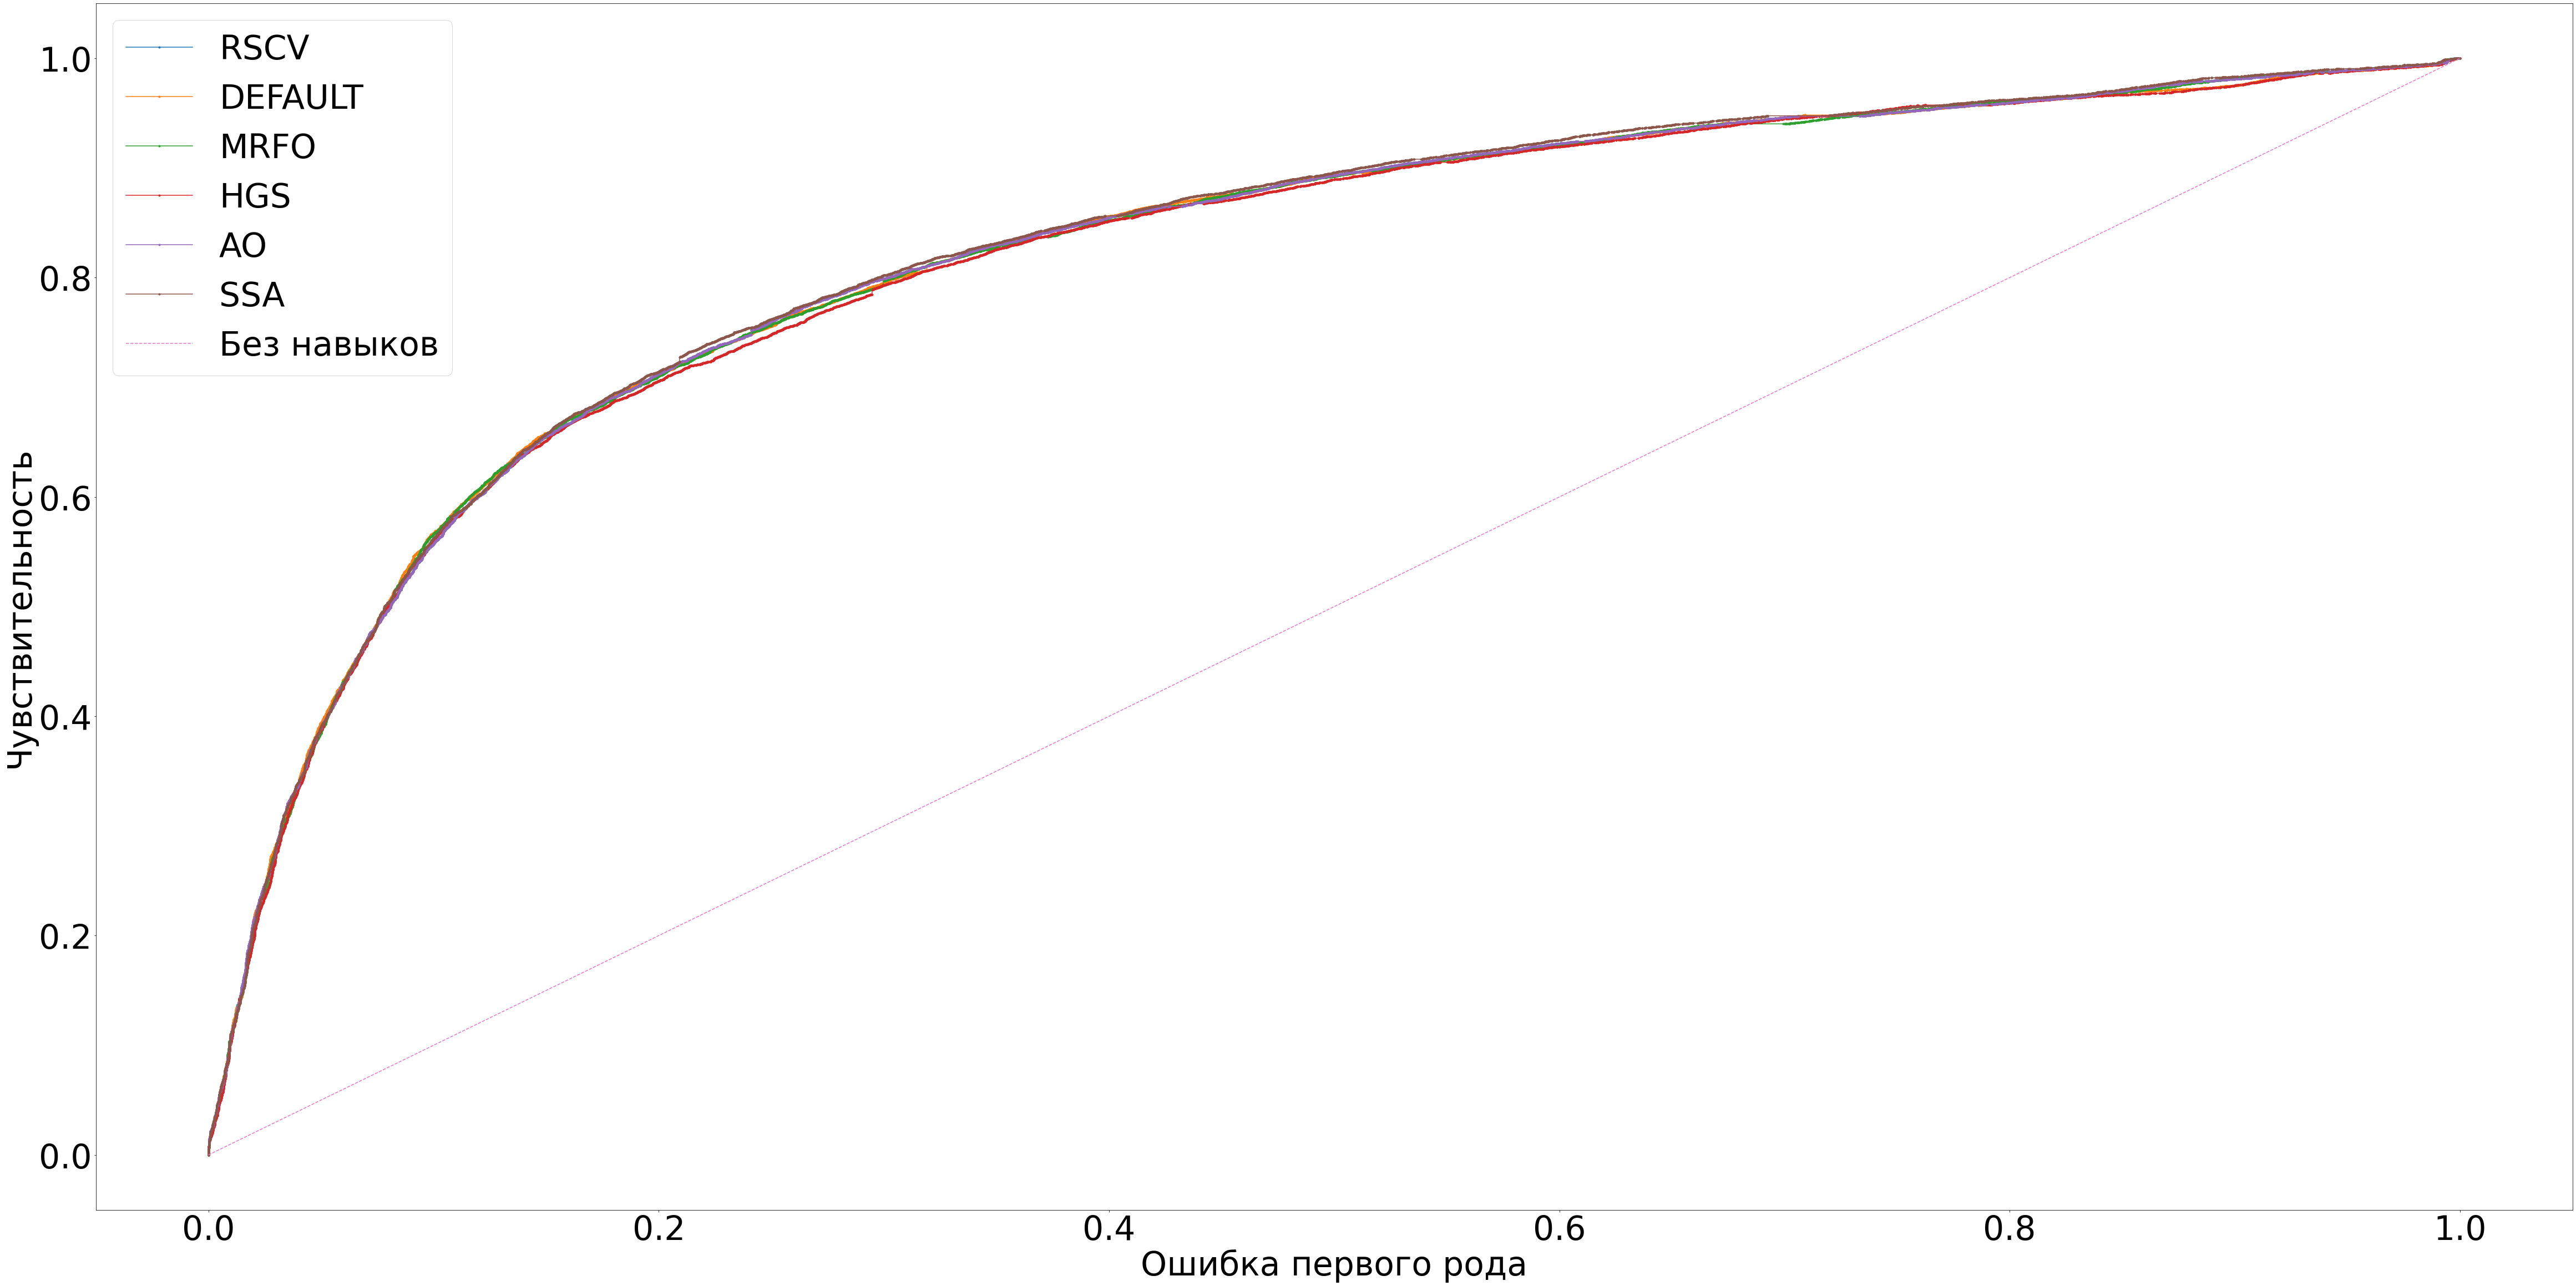

In [31]:
test(ling_spam_clfs, "Ling Spam", "Enron")

Test models trained with Ling Spam on Spam Assasin
RSCV
Accuracy: 0.8897074756229686
Confusion matrix [[6182  767]
 [ 251 2030]]
ROC: 0.8897924750053137

DEFAULT
Accuracy: 0.8871072589382448
Confusion matrix [[6163  786]
 [ 256 2025]]
ROC: 0.8873293613032991

MRFO
Accuracy: 0.8855904658721561
Confusion matrix [[6154  795]
 [ 261 2020]]
ROC: 0.8855857755909231

HGS
Accuracy: 0.885807150595883
Confusion matrix [[6137  812]
 [ 242 2039]]
ROC: 0.8885274179910009

AO
Accuracy: 0.8897074756229686
Confusion matrix [[6182  767]
 [ 251 2030]]
ROC: 0.8897924750053137

SSA
Accuracy: 0.8864572047670639
Confusion matrix [[6162  787]
 [ 261 2020]]
ROC: 0.886161397982634



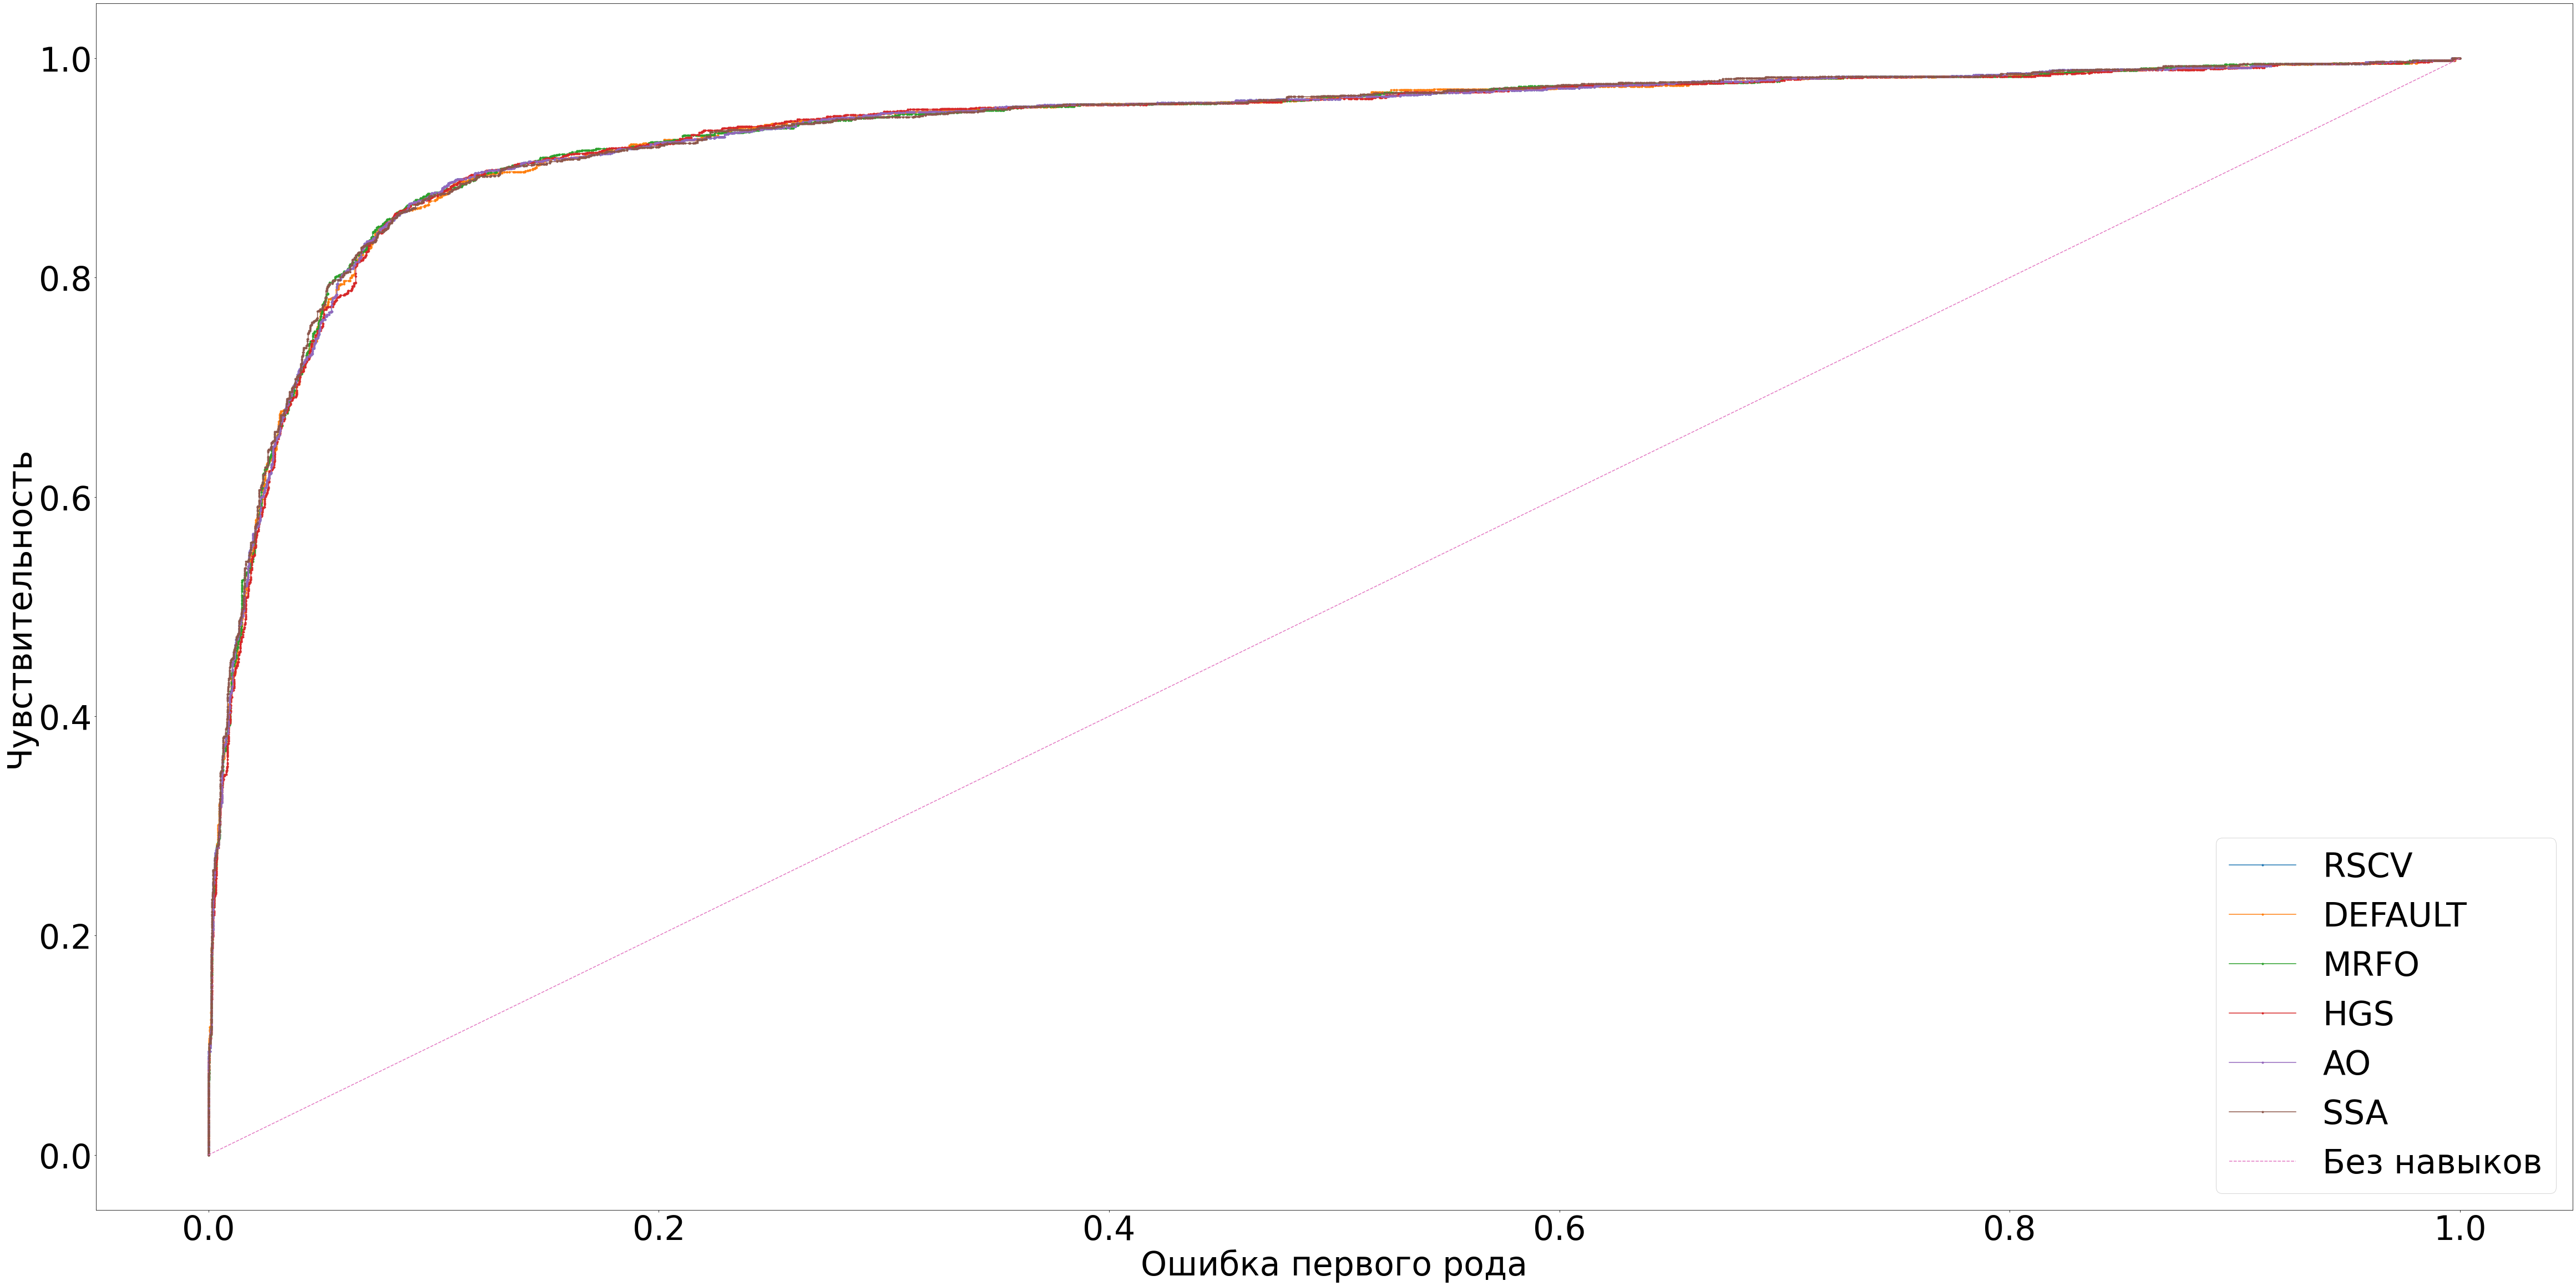

In [35]:
test(ling_spam_clfs, "Ling Spam", "Spam Assasin")

In [64]:
spam_assasin_clfs = {
    "RSCV": create_clf(best_spam_assasin_RSCV),
    "DEFAULT": create_clf(DEFAULT_PARAMS),
    "MRFO": create_clf(best_spam_assasin_MRFO),
    "HGS": create_clf(best_spam_assasin_HGS),
    "AO": create_clf(best_spam_assasin_AO),
    "SSA": create_clf(best_spam_assasin_SSA)
}

In [65]:
print('Train cross-val accuracy scores:')
for alg in spam_assasin_clfs:
    print('Spam Assasin %s %.3f' % (alg, 100*mean(cross_val_score(spam_assasin_clfs[alg], X_spam_assasin, y_spam_assasin, cv=10))))

Train cross-val accuracy scores:
Spam Assasin RSCV 99.198
Spam Assasin DEFAULT 99.198
Spam Assasin MRFO 99.209
Spam Assasin HGS 99.220
Spam Assasin AO 99.198
Spam Assasin SSA 99.155


In [66]:
for alg in spam_assasin_clfs:
    spam_assasin_clfs[alg].fit(X_spam_assasin, y_spam_assasin)

Test models trained with Spam Assasin on Enron
RSCV
Accuracy 0.71731: 
Confusion matrix
 [[14784  1761]
 [ 7770  9400]]
ROC: 0.72051

DEFAULT
Accuracy 0.71722: 
Confusion matrix
 [[14661  1884]
 [ 7650  9520]]
ROC: 0.72029

MRFO
Accuracy 0.71698: 
Confusion matrix
 [[14591  1954]
 [ 7588  9582]]
ROC: 0.71998

HGS
Accuracy 0.71760: 
Confusion matrix
 [[14578  1967]
 [ 7554  9616]]
ROC: 0.72058

AO
Accuracy 0.71731: 
Confusion matrix
 [[14784  1761]
 [ 7770  9400]]
ROC: 0.72051

SSA
Accuracy 0.71339: 
Confusion matrix
 [[14750  1795]
 [ 7868  9302]]
ROC: 0.71663



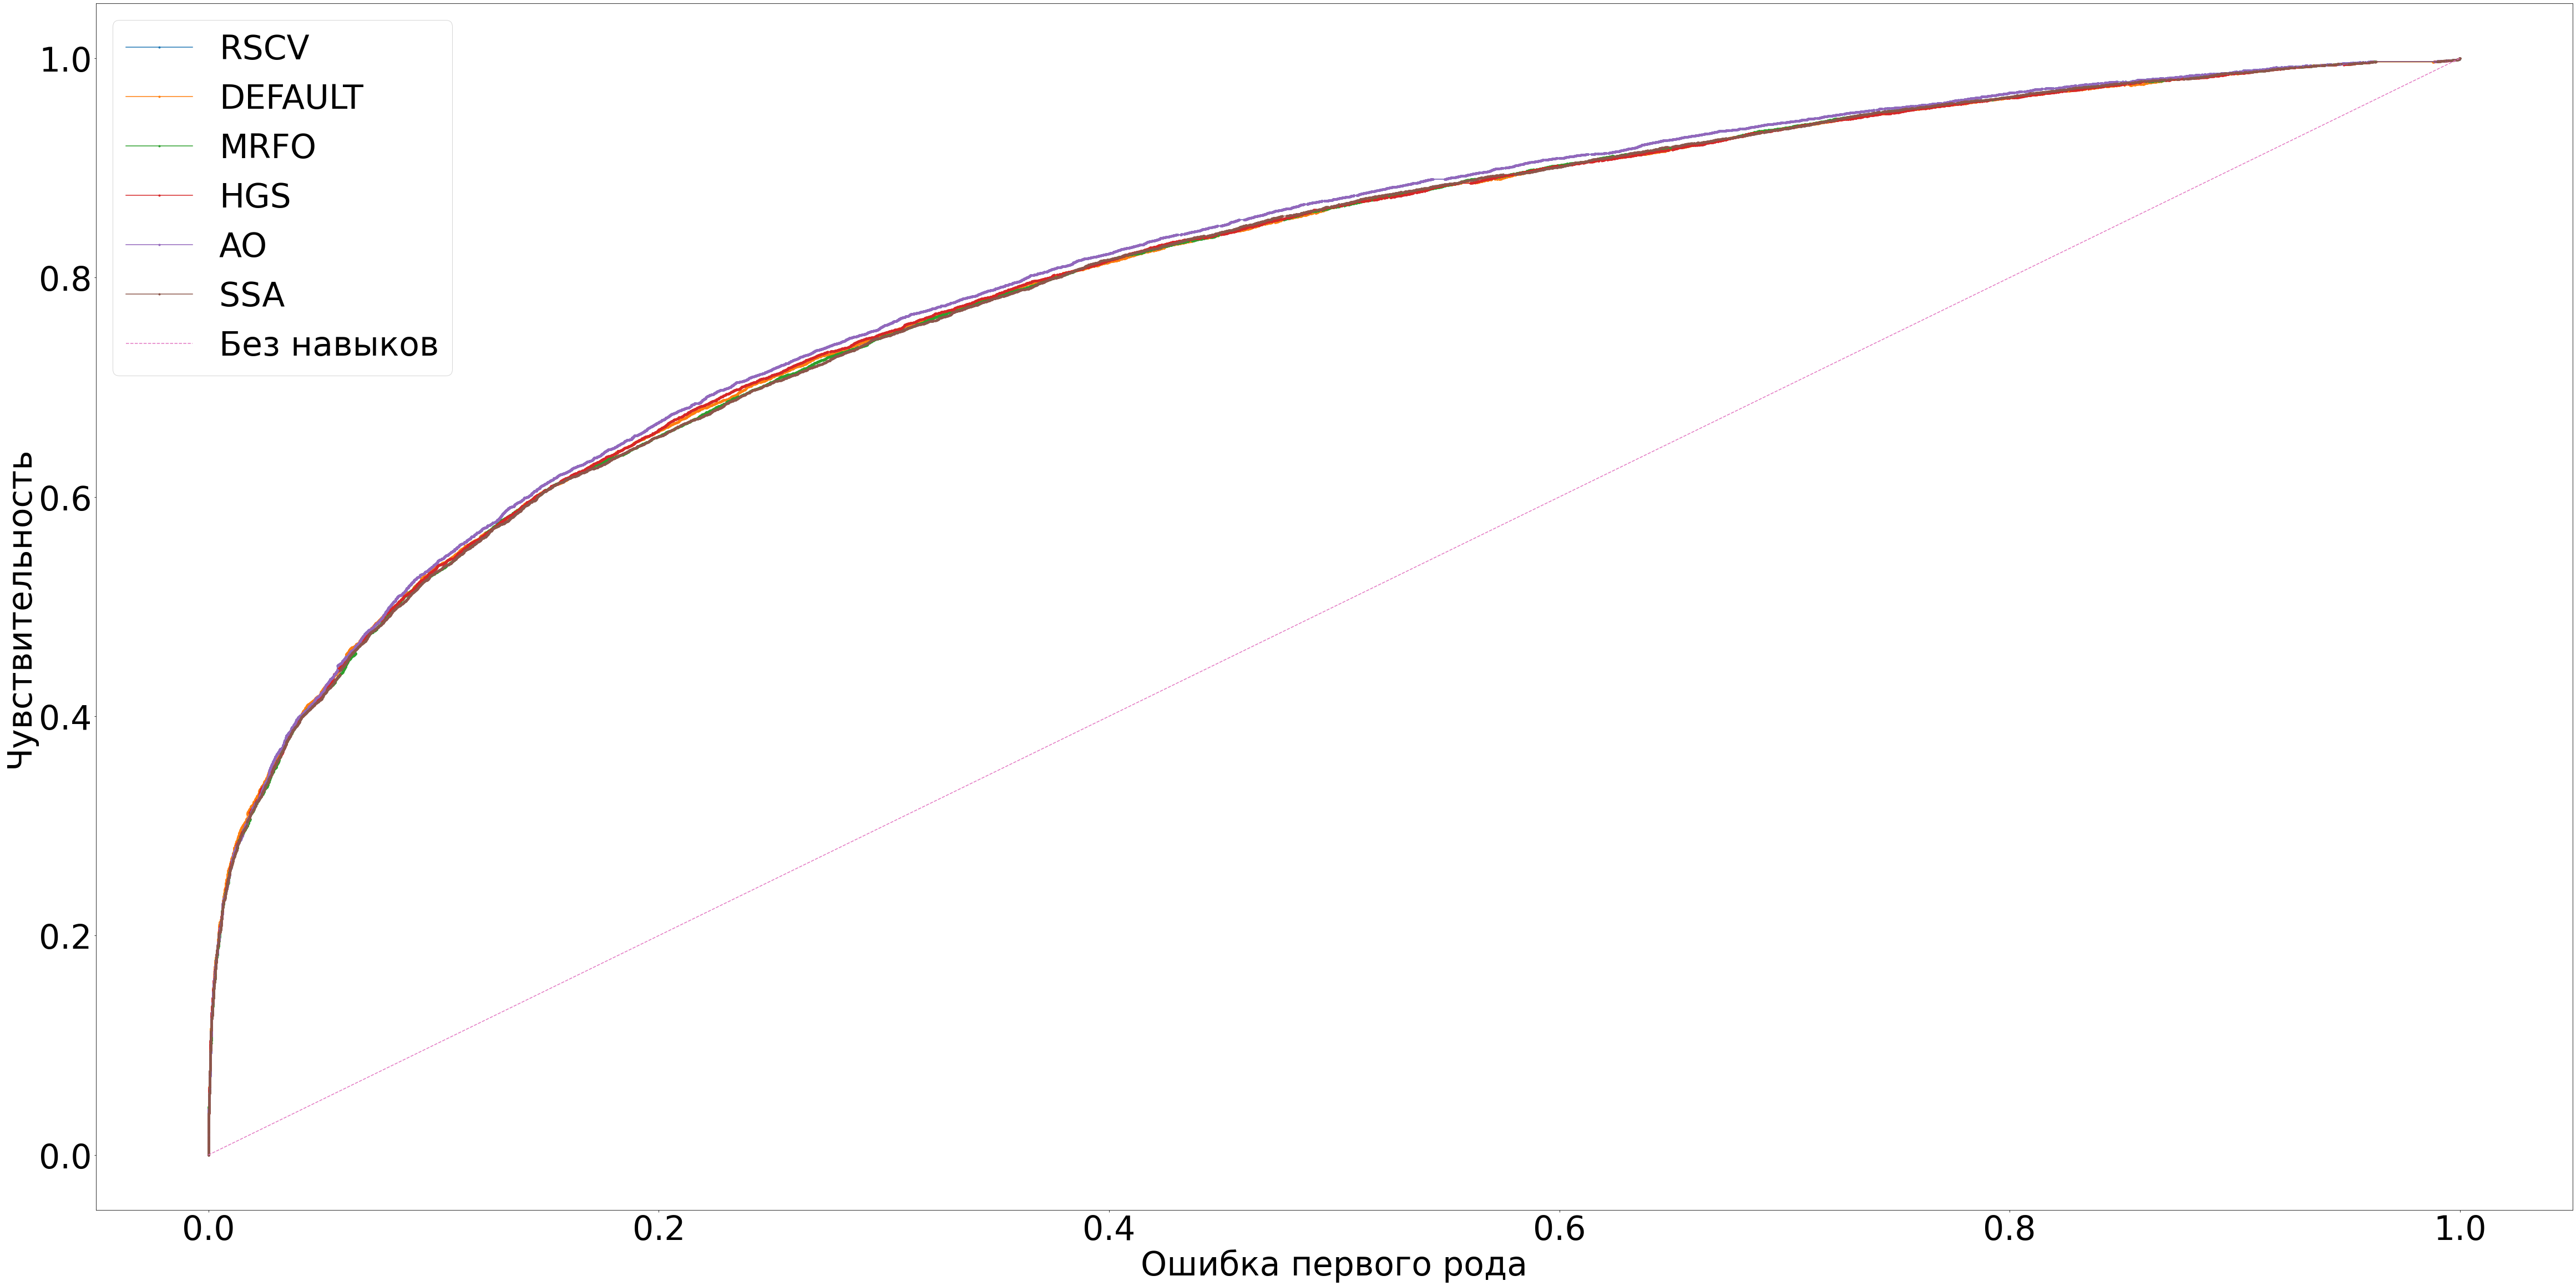

In [67]:
test(spam_assasin_clfs, "Spam Assasin", "Enron")

Test models trained with Spam Assasin on Ling Spam
RSCV
Accuracy 0.93087: 
Confusion matrix
 [[2281  131]
 [  69  412]]
ROC: 0.90112

DEFAULT
Accuracy 0.92741: 
Confusion matrix
 [[2269  143]
 [  67  414]]
ROC: 0.90071

MRFO
Accuracy 0.93018: 
Confusion matrix
 [[2276  136]
 [  66  415]]
ROC: 0.90320

HGS
Accuracy 0.92637: 
Confusion matrix
 [[2268  144]
 [  69  412]]
ROC: 0.89842

AO
Accuracy 0.93087: 
Confusion matrix
 [[2281  131]
 [  69  412]]
ROC: 0.90112

SSA
Accuracy 0.93087: 
Confusion matrix
 [[2281  131]
 [  69  412]]
ROC: 0.90112



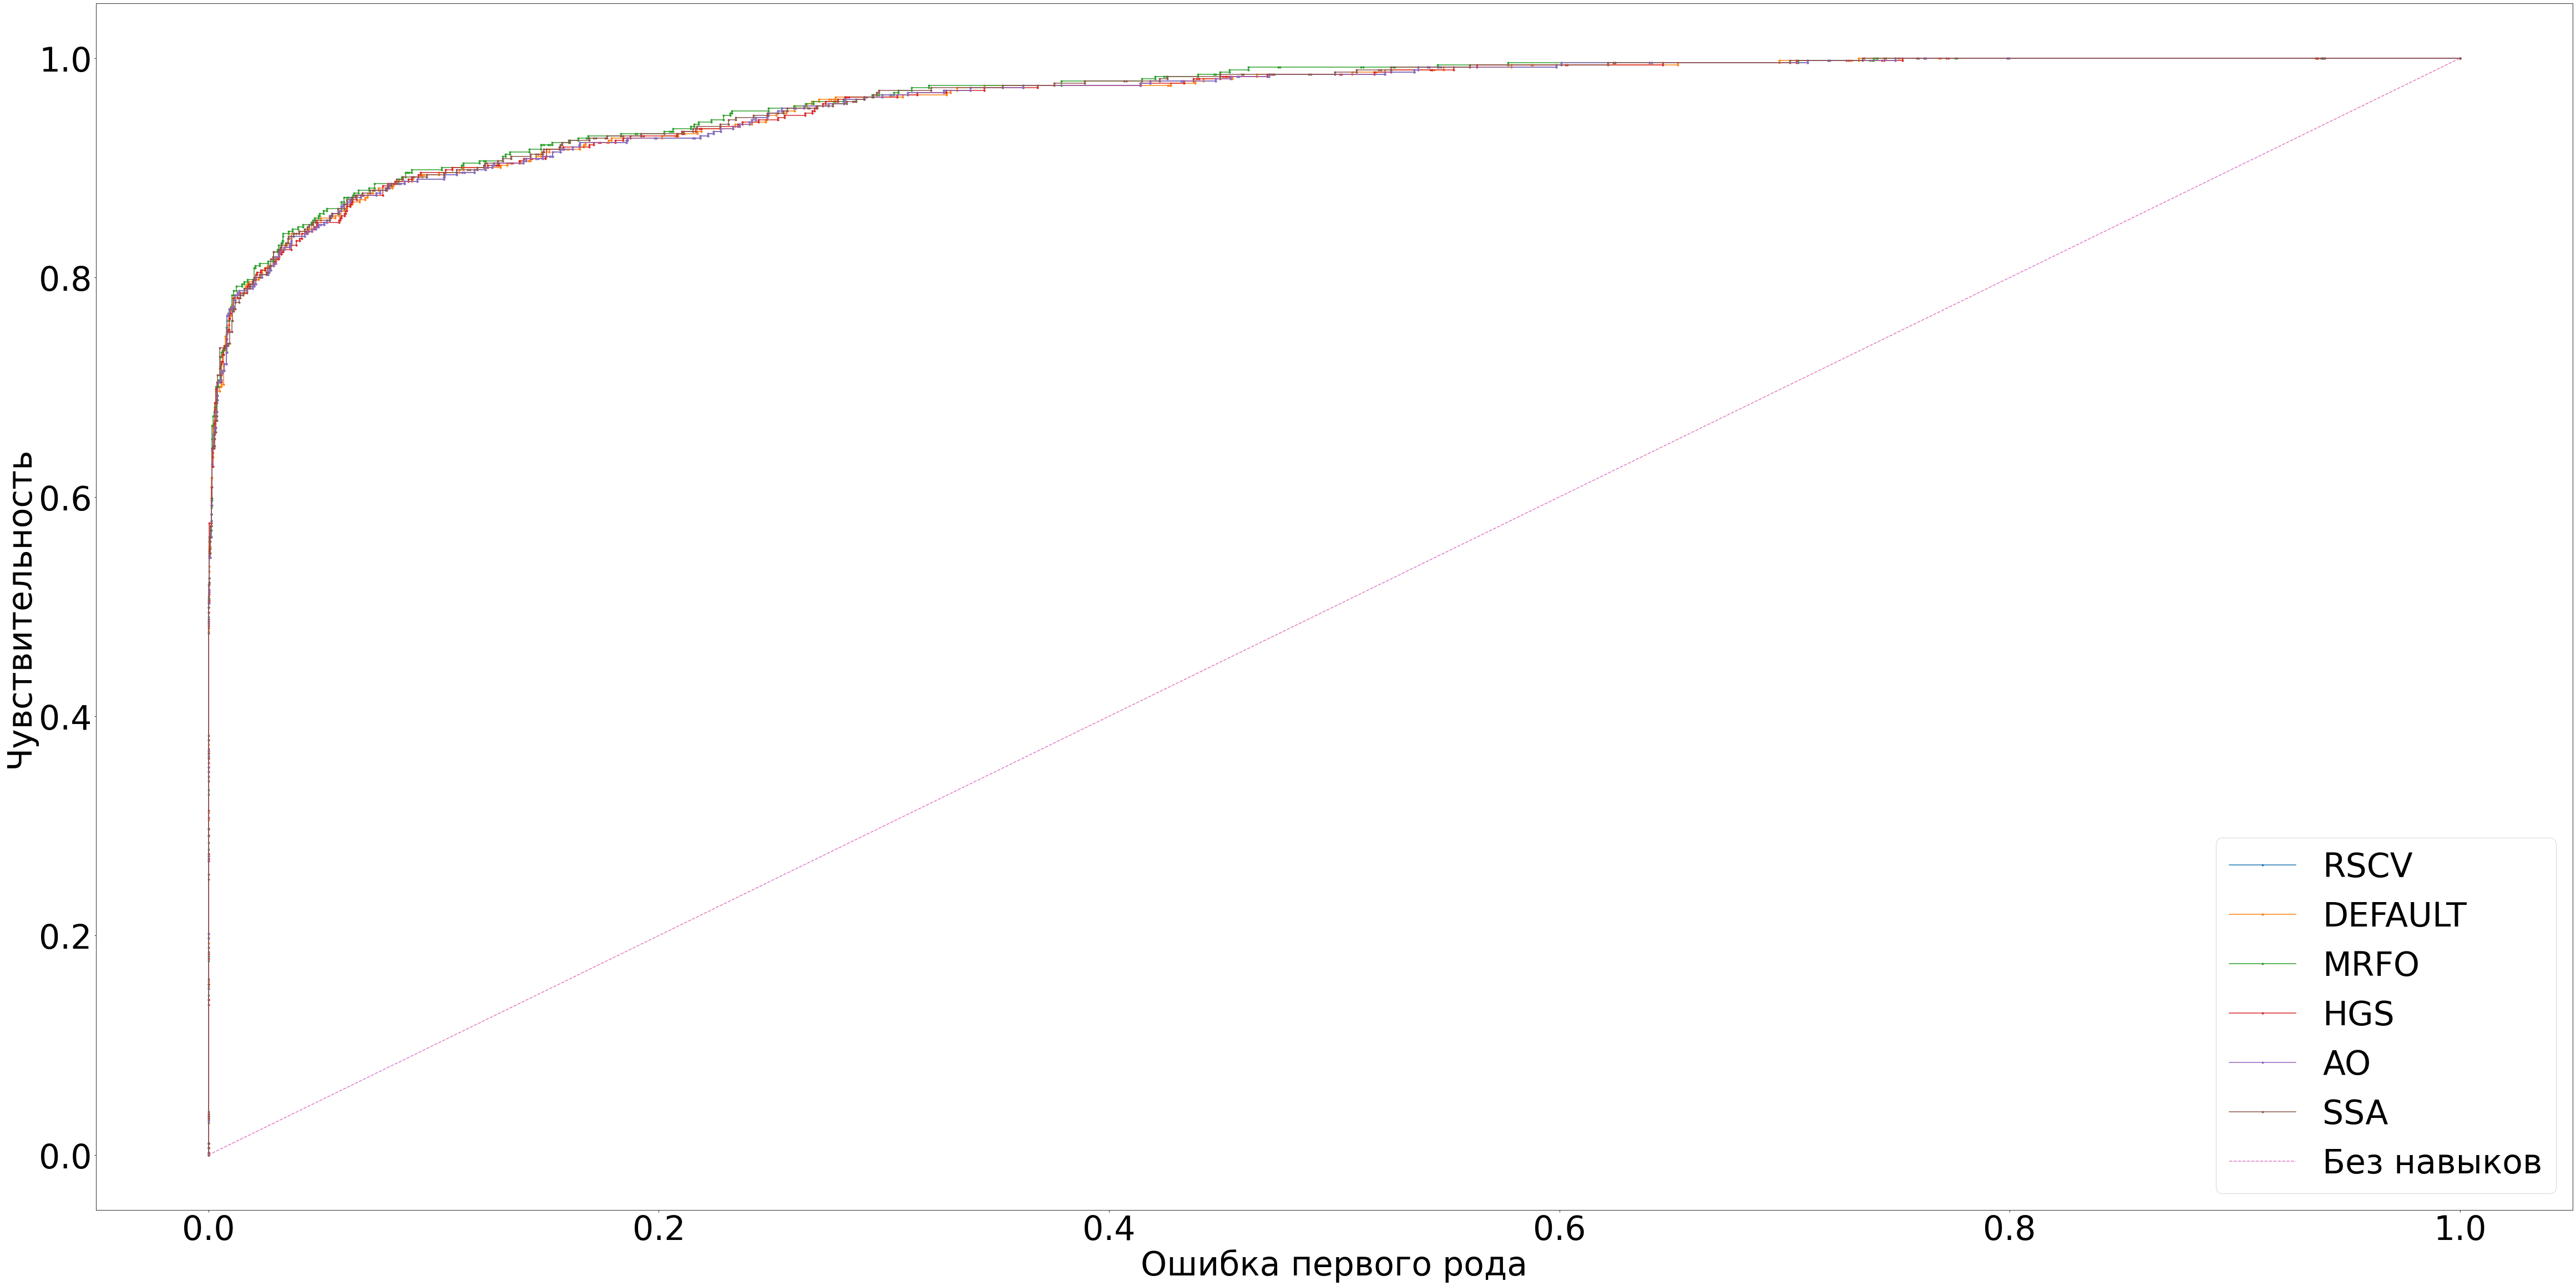

In [68]:
test(spam_assasin_clfs, "Spam Assasin", "Ling Spam")

In [ ]:
enron_clfs = {
    "RSCV": create_clf(best_enron_RSCV),
    "DEFAULT": create_clf(best_enron_DEFAULT),
    "MRFO": create_clf(best_enron_MRFO),
    "HGS": create_clf(best_enron_HGS),
    "AO": create_clf(best_enron_AO),
    "SSA": create_clf(best_enron_SSA)
}

In [ ]:
print('Train cross-val accuracy scores:')
for alg in enron_clfs:
    print('Enron %s %.3f' % (alg, 100*mean(cross_val_score(enron_clfs[alg], X_enron, y_enron, cv=10))))

In [ ]:
for alg in enron_clfs:
    enron_clfs[alg].fit(X_enron, y_enron)

In [ ]:
test(enron_clfs, "Enron", "Spam Assasin")

In [ ]:
test(enron_clfs, "Enron", "Ling Spam")